# Text Mining Dracula in R

By: Tyler Diehl

## Introduction

The purpose of this project is to analyze the text of *Dracula* by Bram Stoker and introduce a practical application to analyzing text from Dr. Godat's workshop "Intro to Working with Text in Python." To preface, *Dracula* is a novel comprised of various different letter and journal and diary entries written by different characters. In regards to analysis, our focus is on determining whether Bram Stoker used a different style of writing for each of his character's writings and how sentiment changes in writings as the novel progresses.

## Setup

There are a few packages that we will be using for text manipulation and analysis. We will load in the book using gutenbergr, which is a package that links directly Project Gutenberg, an eLibrary with over 60,000 free books.

In [61]:
options(warn=-1)
library(gutenbergr)
library(tidyverse)
library(splitstackshape)
library(sjmisc)
library(gdata)
library(qdapRegex)
library(stopwords)
library(mgsub)
library(textstem)
library(tidytext)
library(wordcloud)

## Loading in Dracula From the Gutenberg Project

The first thing that we can do is find the IDs from Project Gutenberg where the title is Dracula. The call gutenberg_metadata$gutenberg_id will grab the metadata that Project Gutenberg has for the books in its library titled Dracula.

In [2]:
DraculaID <- gutenberg_metadata$gutenberg_id[which(gutenberg_metadata$title == "Dracula")]
gutenberg_metadata[which(gutenberg_metadata$title == "Dracula"),]

gutenberg_id,title,author,gutenberg_author_id,language,gutenberg_bookshelf,rights,has_text
345,Dracula,"Stoker, Bram",190,en,Gothic Fiction/Movie Books/Horror/Mystery Fiction,Public domain in the USA.,TRUE
6534,Dracula,"Stoker, Bram",190,en,Movie Books/Horror,Copyrighted. Read the copyright notice inside this book for details.,FALSE
19797,Dracula,"Stoker, Bram",190,en,Horror/Movie Books,Public domain in the USA.,TRUE
45839,Dracula,"Stoker, Bram",190,en,NA,Public domain in the USA.,TRUE


So it looks like there are 4 different versions of Dracula. Lets just take the first one for simplicty.

We can now download Dracula and look at a portion of it so we know how it is formatted when we download it. 
gutenberg_download is the function used to download books. It takes the ID of the book which we found above. 

In [3]:
DraculaID <- DraculaID[1]
my_mirror <- "http://mirrors.xmission.com/gutenberg/"
Dracula <- gutenberg_download(DraculaID, mirror = my_mirror)
Dracula[80:90,]

gutenberg_id,text
345,CHAPTER I
345,
345,JONATHAN HARKER'S JOURNAL
345,
345,(_Kept in shorthand._)
345,
345,
345,"_3 May. Bistritz._--Left Munich at 8:35 P. M., on 1st May, arriving at"
345,"Vienna early next morning; should have arrived at 6:46, but train was an"
345,"hour late. Buda-Pesth seems a wonderful place, from the glimpse which I"


### How to think about the text for cleaning

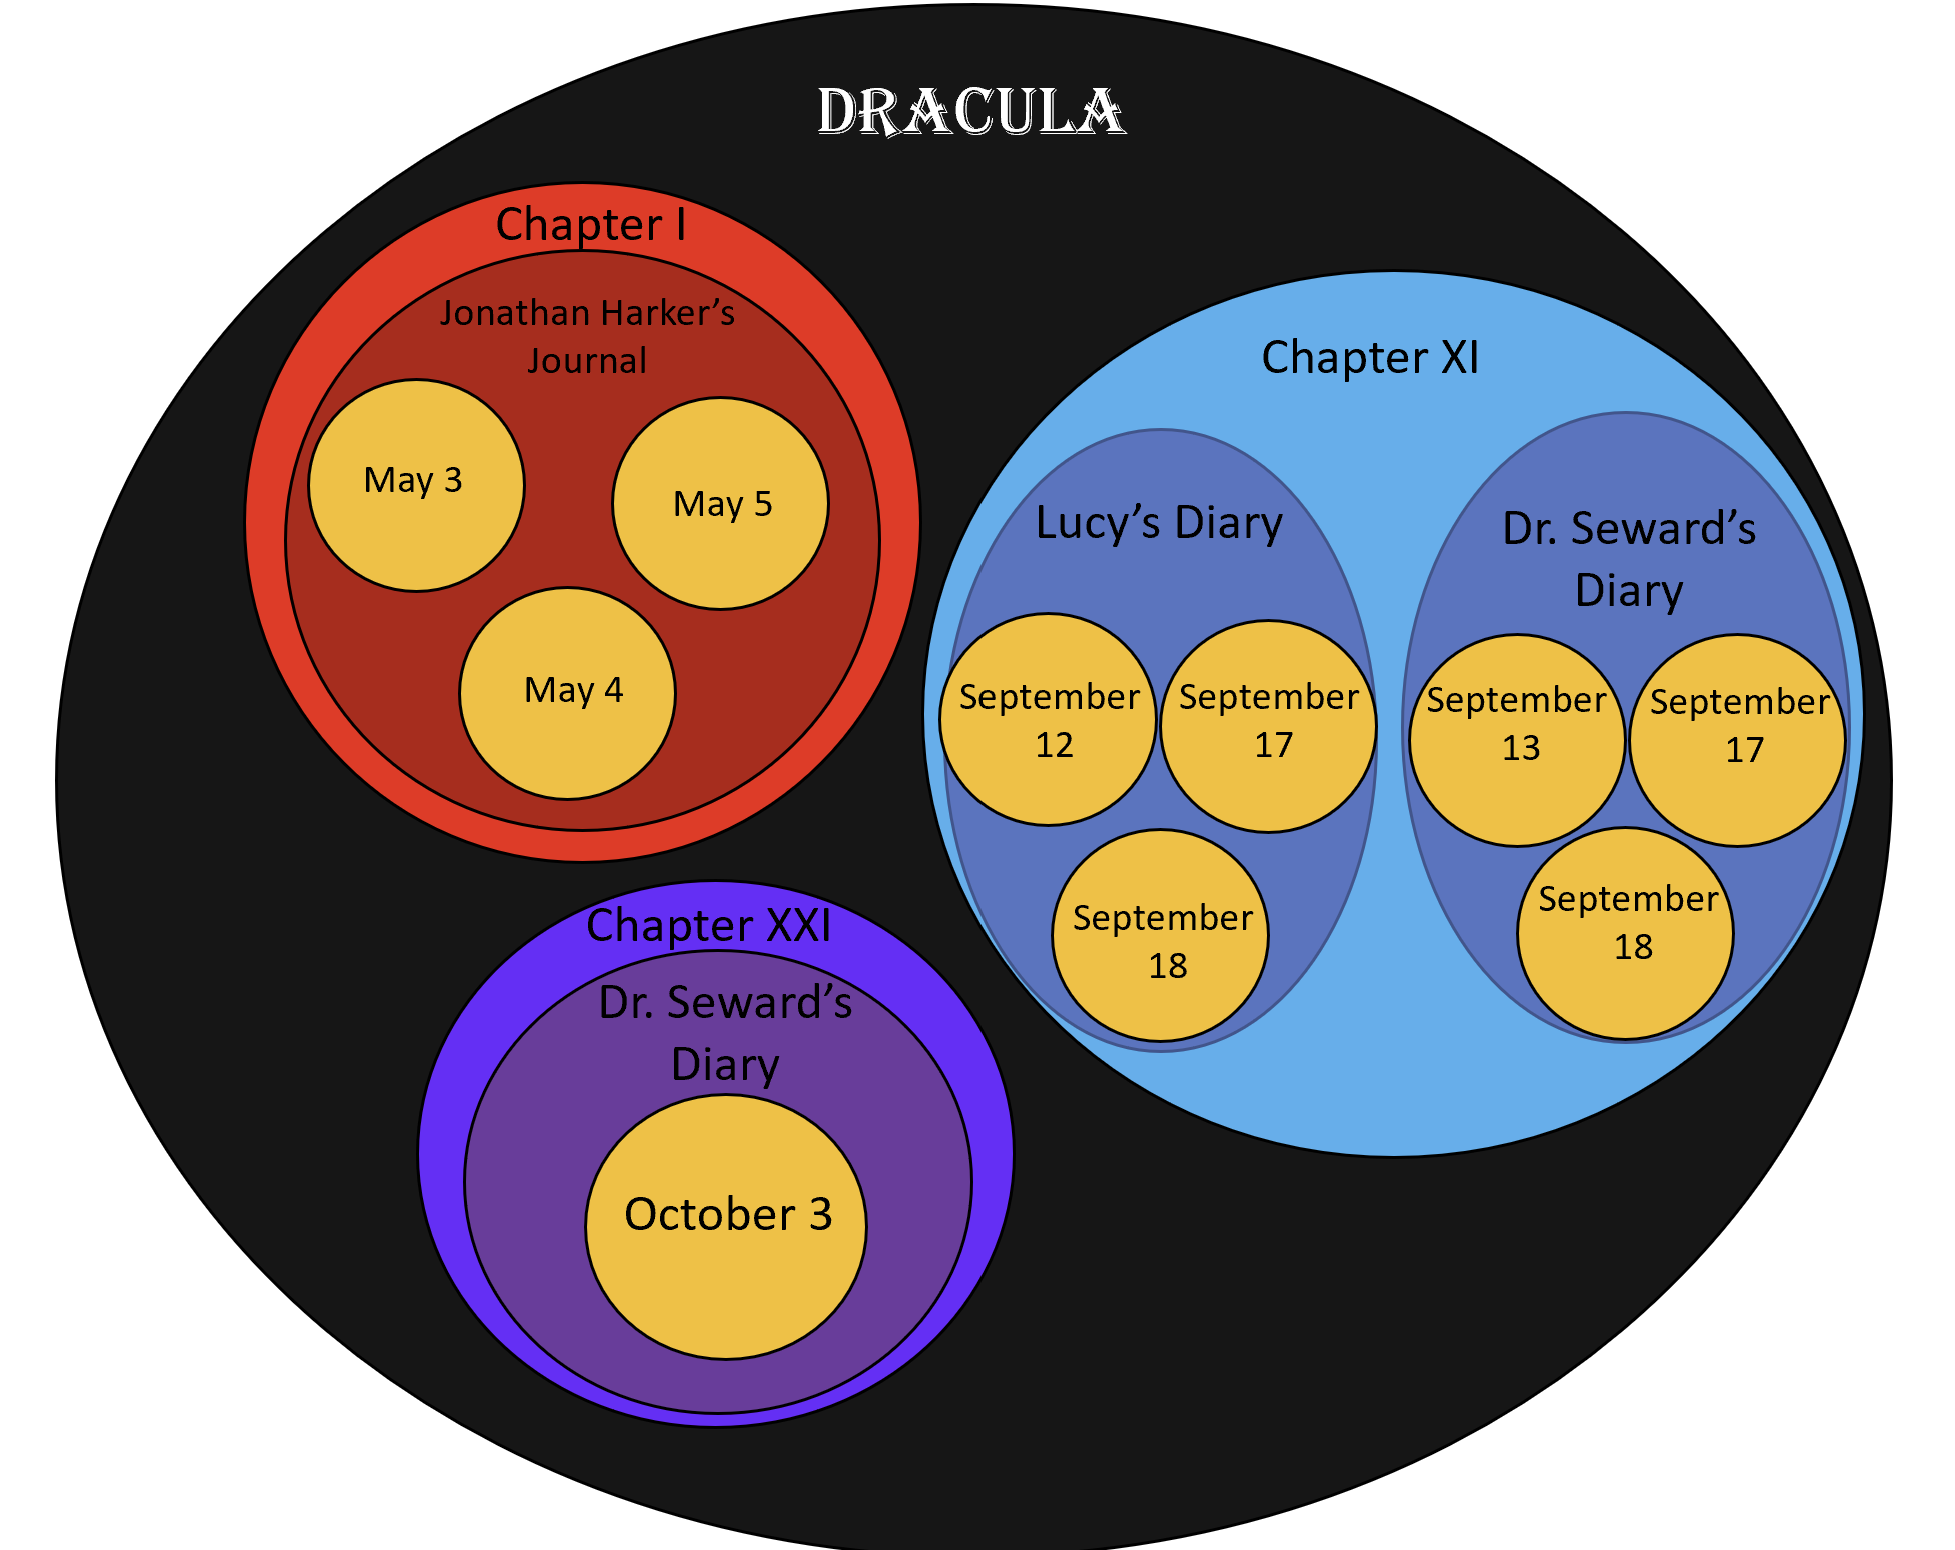

## Cleaning the Text

Now we can get to actually cleaning the text so we can analyze it. Since we are concerned about each individual entry within the book, we are going to have to split up the text a lot. As we can see above, there are some patterns that we can use to distinguish the place at which entries start.

For example, new entries start with an underscore at the beginning of the line. Additionally within the chapter, when different authors are starting new entries, there is an underscore demarking it. We also know that chapters will just have the form "Chapter #".

Using this information, we can find the index of each new entry, author, and chapter to assign the text a place in a df with author, date, and chapter. This will help us determine who is talking in the text and when it's happening because the text is not directly in chronological order although it follows an almost linear pattern.

It's always a good idea to look through a lot of your text at the beginning, and if working in RStudio, you can use view(Dracula) to look through the text to see if there are some irregularities. I didn't find this until later, but chapter 7 has some weird stuff going on with the captain's log. It isn't formatted like the rest of the book, and it really isn't important to our analysis, so we'll get rid of it now.

In [4]:
Dracula <- Dracula %>% slice(-3027:-3493)

### The Approach to Cleaning Dracula

Considering that we are given the text as a dataframe of each line of the text, we need a method to approach how we want to separate the different entries, determining who wrote the entries, and when the entries were written. The approach we will use is by determing the line number that each chapter starts, the line number each new diary/letter starts, and the linenumber that each new entry within the diaries/letters start. Once we find all of these, we can analyze the text by author and time. 

#### Determining the Line Number of Each New Entry

To start we can define a group of months that we know the text takes place during. We will list them all out in the same string with pipes inbetween because we want to specify that it can be any of those months. 
In this case, a pipe indicates "or".
We can then use str_detect to determine if any of the months are in the text of Dracula in between underscores (our marker for new entries/new author entries). We can then use grep() to find the place of each TRUE in the text. Adding back 70 because we only looked past line 70 in the book gets us to the correct place within the entire book.

In [5]:
drac_dates <- "May|June|July|August|September|October|November"
NewEntryPlace <- grep(TRUE, str_detect(rm_between(Dracula$text[71:nrow(Dracula)], '_', '_', extract=TRUE), drac_dates))
NewEntryPlace <- NewEntryPlace + 70

#### Determining the Line Number of Each New Diary/Letter Entry

Now that we've gone through and found the new entries, lets find when new authors are introduced as starting new journal/diary or letter entries. 

We can start by assigning the names of authors that appear throughout the text. This takes the exact same form as above, but this time we use Author Names.
At the end, we need to add the ending of the book for later use so that we know where to stop looking in the text.

In [6]:
drac_auths <- "Jonathan|Mina|Seward|Lucy|Quincey|Arthur|Samuel|Carter|Agatha|Van Helsing|Gazette|Patrick|Mrs. Harker|Mitchell"
NewAuthPlace <- grep(TRUE, str_detect(rm_between(Dracula$text[71:nrow(Dracula)], '_', '_', extract=TRUE), drac_auths))
NewAuthPlace <- NewAuthPlace + 70
grep("NOTE", Dracula$text)
NewAuthPlace <- append(NewAuthPlace, 14897)

[1] 14897

#### Determining the Line Number of Each Chapter

Moving on to chapter places, we know that the chapter of the text are contained within the table of contents, which in the dataframe are from lines 44-70. Using this information we can look up the places of each chapter by finding a match in the text. 

First we clean the table of contents so that we're only left with the form "Chapter I."
This is an example of what the table of contents looks like:

In [7]:
Dracula[44:50,]

gutenberg_id,text
345,CHAPTER I. Jonathan Harker’s Journal
345,CHAPTER II. Jonathan Harker’s Journal
345,CHAPTER III. Jonathan Harker’s Journal
345,CHAPTER IV. Jonathan Harker’s Journal
345,CHAPTER V. Letters—Lucy and Mina
345,CHAPTER VI. Mina Murray’s Journal
345,"CHAPTER VII. Cutting from “The Dailygraph,” 8 August"


Here we can split the text between the chapter number and the title of the chapter by using cSplit and specifying the split by a period.
After that we just need to convert the text to blanks if NA and into character form. We additionally need to consider where the title's also had a period in it which was Dr. Sewards name so we add the period back - this isn't completely necessary so feel free to skip over.

In [8]:
DraculaChapters <- data.frame("Chapters" = Dracula$text[44:70])

DraculaChapters <- cSplit(DraculaChapters, "Chapters", sep = ".")

DraculaChapters <- sapply(DraculaChapters, as.character)
DraculaChapters[which(is.na(DraculaChapters))] <- ""
DraculaChapters <- as.data.frame(DraculaChapters)
DraculaChapters <- data.frame('Chapter' = DraculaChapters$Chapters_1, 'Title' = paste(DraculaChapters$Chapters_2, DraculaChapters$Chapters_3))

DraculaChapters$Title <- gsub("Dr", "Dr.", DraculaChapters$Title)

head(DraculaChapters)

Chapter,Title
CHAPTER I,Jonathan Harker’s Journal
CHAPTER II,Jonathan Harker’s Journal
CHAPTER III,Jonathan Harker’s Journal
CHAPTER IV,Jonathan Harker’s Journal
CHAPTER V,Letters—Lucy and Mina
CHAPTER VI,Mina Murray’s Journal


Now that we know what to look for in the actual text for chapter places, we can search throught the text and find out where the place in the dataframe is for the start of new chapters.

In [9]:
ChapterPlace <- which(Dracula$text[71:nrow(Dracula)] %in% DraculaChapters$Chapter)
ChapterPlace <- ChapterPlace + 70
ChapterPlace <- append(ChapterPlace, 14897)
ChapterPlace

[1]    80   586  1088  1587  2157  2500  3025  3102  3694  4268  4865  5378
[13]  6092  6751  7394  7987  8425  8972  9613 10105 10723 11286 11782 12330
[25] 12913 13515 14221 14897

#### Putting it all Together

Now that we have all of the places of authors, it's time to put this all in its own dataframe so that we can see where each entry is, who wrote it, and the text contained.
We will start by creating a dataframe that contains each entry we already got earlier. After, we need to add a 0 to the start of the author place so that we are able to take minimum values.
With our for loop, we will assign the author place for each entry, or basically what journal/diary/letter the entry is contained within.
Our reasoning for assigning journals to new entries is that we want to only do assign the previous place of the author entry if that comes after the new chapter has started. 
So given each new entry's place, we want to see what comes before it first, the start of a new chapter or the start of a new author entry.
To accomplish this, we create a for loop that goes through all of the new entries and finds the closest author entry OR chapter entry (if this comes before the closest previous author entry)
Taking the minimum of the difference between the closest previous chapter and the closest previous author entry will give us who is writing. If an entry comes after a chapter but before the new author entry, we know that whoever is writing is the person specified in the title of the chapter. Additionally, we will want to assign the author place as 0 if it is an entry without one.

In [10]:
DraculaEntries <- data.frame("NewEntryPlace" = NewEntryPlace)
NewAuthPlace <- append(NewAuthPlace, 0, after = 0)
MinValueHolder <- vector()
difference <- integer()
MinVal <- integer()

for(val in 1:length(ChapterPlace))
{
  for(val2 in 1:nrow(DraculaEntries))
  {
    if(DraculaEntries$NewEntryPlace[val2] > ChapterPlace[val] & DraculaEntries$NewEntryPlace[val2] < ChapterPlace[val + 1])
    {
      for(val3 in 1:length(NewAuthPlace))
      {
        difference <- DraculaEntries$NewEntryPlace[val2] - NewAuthPlace[val3]
        MinValueHolder <- append(MinValueHolder, difference)
        MinVal <- min(MinValueHolder[MinValueHolder > 0])
      }
      if(MinVal != DraculaEntries$NewEntryPlace[val2])
      {
        DraculaEntries$AuthorPlace[val2] <- DraculaEntries$NewEntryPlace[val2] - MinVal
      }
      else {DraculaEntries$AuthorPlace[val2] <- 0}
    }
    MinValueHolder <- vector()
  }
}
DraculaEntries[20:25,]

,NewEntryPlace,AuthorPlace
20,2258,2256
21,2430,2426
22,2464,2462
23,2490,2488
24,2505,2488
25,2587,2488


Here we can go through and grab the chapter place which is basially just taking all of the previous chapter places from the new entry place and finding the minimum (or closest)

In [11]:
for(val in 1:nrow(DraculaEntries))
{
  for(val2 in 1:length(ChapterPlace))
  {
    difference <- DraculaEntries$NewEntryPlace[val] - ChapterPlace[val2]
    MinValueHolder <- append(MinValueHolder, difference)
  }
  MinVal <- min(MinValueHolder[MinValueHolder > 0])
  DraculaEntries$ChapterPlace[val] <-DraculaEntries$NewEntryPlace[val] - MinVal
  MinValueHolder <- vector()
}
head(DraculaEntries)

NewEntryPlace,AuthorPlace,ChapterPlace
87,0,80
206,0,80
263,0,80
591,0,586
773,0,586
1021,0,586


Because we are just grabbing the previous new author entry, regardless of where the new chapter starts, we need to account for that. The Author attributed to the entry will not be the one we got if it was before the new chapter started.


In [12]:
DraculaEntries$AuthorPlace[which(DraculaEntries$AuthorPlace < DraculaEntries$ChapterPlace)] <- 0

#### Assigning Dates to Entries

We should think about grabbing the date for each entry so that if we graph anything we know when it took place and we can plot our entries over time. A simple for loop should be able to extract the first line of an entry, containing the date. From there, we will have to decide how we want to remove the date based on the format.

In [13]:
for(val in 1:nrow(DraculaEntries))
{
  DraculaEntries$date[val] <- rm_between(Dracula$text[DraculaEntries$NewEntryPlace[val]], '_', '_', extract=TRUE)[[1]][1]
}
head(DraculaEntries)

NewEntryPlace,AuthorPlace,ChapterPlace,date
87,0,80,3 May. Bistritz.
206,0,80,4 May.
263,0,80,5 May. The Castle.
591,0,586,5 May.
773,0,586,7 May.
1021,0,586,8 May.


Furthermore, we can get the dates down to the right format to graph later by searching through the text for the day and month. If you remember, we had a string named drac_entries assigned with the dates in them, but separated by a pipe. We need to first change this to a vector with the separate dates in order to look throught the text. Additionally, we should clean up and look through our date entry so we know what to look for

In [14]:
drac_dates_separate <- strsplit(drac_dates, "\\|")
drac_dates_separate <- unlist(drac_dates_separate)

DraculaEntries[118:127,]

,NewEntryPlace,AuthorPlace,ChapterPlace,date
118,10078,9962,9613,2 October 10 p. m.
119,10110,0,10105,"1 October, evening."
120,10178,0,10105,"2 October, evening."
121,10426,10424,10105,1 October.
122,10644,10642,10105,"""1 October."
123,10667,10665,10105,2 October.
124,10728,0,10723,3 October.
125,11291,0,11286,3 October.
126,11787,0,11782,3 October.
127,12125,12123,11782,"3-4 October, close to midnight."


The dates sometimes contain more than one number, but they usually come after a comma. Here we will separate our strings by commas so that we can search and see which one contains the month and date. For ones that still have 2 numbers, like the time, we can just manually change it to make it easier. For rows 118 and 127, we will just manually change this.  

In [15]:
DraculaEntries$date <- gsub("\\.", "", DraculaEntries$date)
DraculaEntries <- cSplit(DraculaEntries, "date", sep = ",")
DraculaEntries$date_1[118] <- "2 October"
DraculaEntries$date_1[127] <- "3 October"

Now, we are ready to look for the days and the months for each entry. We can do this by running a couple for loops looking through each date and determining if it has a date. If it does, we will take the month and the day and assign them to separate columns in the dataframe. After that, we can format the day and month as a date in our dataframe.

In [16]:
for(val in 1:nrow(DraculaEntries))
{
  for(val2 in 1:length(drac_dates_separate))
  {
  if(str_contains(DraculaEntries$date_1[val], drac_dates_separate[val2], ignore.case = T))
     {
       DraculaEntries$month[val] <- drac_dates_separate[val2]
       DraculaEntries$day[val] <- regmatches(DraculaEntries$date_1[val], gregexpr("[[:digit:]]+", DraculaEntries$date_1[val]))
     }
    else if(str_contains(DraculaEntries$date_2[val], drac_dates_separate[val2], ignore.case = T))
    {
      DraculaEntries$month[val] <- drac_dates_separate[val2]
      DraculaEntries$day[val] <- regmatches(DraculaEntries$date_2[val], gregexpr("[[:digit:]]+", DraculaEntries$date_2[val]))
    }
  }
}

DraculaEntries$date <- paste(DraculaEntries$month, DraculaEntries$day)
DraculaEntries$date <- as.Date(DraculaEntries$date, format = "%b %d")
DraculaEntries$date <- format(DraculaEntries$date, format = "%b-%d")
head(DraculaEntries)

NewEntryPlace,AuthorPlace,ChapterPlace,date_1,date_2,month,day,date
87,0,80,3 May Bistritz,NA,May,3,May-03
206,0,80,4 May,NA,May,4,May-04
263,0,80,5 May The Castle,NA,May,5,May-05
591,0,586,5 May,NA,May,5,May-05
773,0,586,7 May,NA,May,7,May-07
1021,0,586,8 May,NA,May,8,May-08


#### Assigning Authors to Entries

We need to get the text that allows us to determine the author - because we know that some entries will have multiple authors, we take the full text for the author entries now so we can cut it down later. For example, when we have an entry "Letter, Lucy Westerna to Mina Murray" how do we decide who is the author computationally?

Here, we can run a basic for loop to grab the text as long as the Author Place isn't 0. If it is we know that the author speaking is in the chapter title, so we can assign the text to the chapter.

In [17]:
for(val in 1:nrow(DraculaEntries))
{
  if(DraculaEntries$AuthorPlace[val] != 0)
  {
    DraculaEntries$textauth[val] <- Dracula$text[DraculaEntries$AuthorPlace[val]]
  }
  else
  {DraculaEntries$textauth[val] <- Dracula$text[DraculaEntries$ChapterPlace[val]]}
}
DraculaEntries[20:25,]

NewEntryPlace,AuthorPlace,ChapterPlace,date_1,date_2,month,day,date,textauth
2258,2256,2157,24 May,NA,May,24,May-24,"_Letter, Lucy Westenra to Mina Murray_."
2430,2426,2157,25 May,NA,May,25,May-25,_Dr. Seward's Diary._
2464,2462,2157,25 May,NA,May,25,May-25,"_Letter, Quincey P. Morris to Hon. Arthur Holmwood._"
2490,2488,2157,26 May,NA,May,26,May-26,_Telegram from Arthur Holmwood to Quincey P. Morris._
2505,0,2500,24 July Whitby,NA,July,24,Jul-24,CHAPTER VI
2587,0,2500,1 August,NA,August,1,Aug-01,CHAPTER VI


Here we can basically just assign the chapter to the chapter index that we got earlier. Then we want to add the title to the chapter so that we get the full title and chapter together.

In [18]:
DraculaEntries$Chapter <- Dracula$text[DraculaEntries$ChapterPlace]
for(val in 1:nrow(DraculaEntries))
{
  for(val2 in 1:nrow(DraculaChapters))
  {
    if(str_contains(DraculaEntries$Chapter[val], DraculaChapters$Chapter[val2]))
    {
      chap <- val2
    }
  }
  DraculaEntries$Chapter[val] <- paste(DraculaEntries$Chapter[val], DraculaChapters$Title[chap])
}
DraculaEntries[20:25,]

NewEntryPlace,AuthorPlace,ChapterPlace,date_1,date_2,month,day,date,textauth,Chapter
2258,2256,2157,24 May,NA,May,24,May-24,"_Letter, Lucy Westenra to Mina Murray_.",CHAPTER V Letters—Lucy and Mina
2430,2426,2157,25 May,NA,May,25,May-25,_Dr. Seward's Diary._,CHAPTER V Letters—Lucy and Mina
2464,2462,2157,25 May,NA,May,25,May-25,"_Letter, Quincey P. Morris to Hon. Arthur Holmwood._",CHAPTER V Letters—Lucy and Mina
2490,2488,2157,26 May,NA,May,26,May-26,_Telegram from Arthur Holmwood to Quincey P. Morris._,CHAPTER V Letters—Lucy and Mina
2505,0,2500,24 July Whitby,NA,July,24,Jul-24,CHAPTER VI,CHAPTER VI Mina Murray’s Journal
2587,0,2500,1 August,NA,August,1,Aug-01,CHAPTER VI,CHAPTER VI Mina Murray’s Journal


We need to list out all of the authors that have entries, so that we can determine computationally which one matches the author entry. Then in another complicated loop, we can grab the names that appear in the title of each new diary/journal entry. If the title only contains one name, then we know whatever name it is is the person who wrote it. If title has more than 1 entry, we can take the first name that appears. The de facto rule which thankfully applies to all of the titles with more than one name is that it is "From Person1 to Person2."

In [19]:
DracNames <- c("Jonathan", "Mina", "Seward", "Lucy", "Quincey", "Arthur", "Samuel",
               "Carter", "Agatha", "Van Helsing", "Gazette", "Patrick", "Mrs. Harker",
               "Mitchell")
for(val in 1:nrow(DraculaEntries))
{
  NameHolder <- vector()
  for(val2 in 1:length(DracNames))
  {
    if(str_contains(DraculaEntries$textauth[val], DracNames[val2]))
    {
      NameHolder <- append(NameHolder, DracNames[val2])
    }
  }
  if(length(NameHolder) > 1)
  {
    spot <- vector()
    for(val3 in 1:length(NameHolder))
    {
      spot <- append(spot, gregexpr(NameHolder[val3], DraculaEntries$textauth[val]))
    }
    if(spot[[1]][1] > spot[[2]][1])
    {
    DraculaEntries$Author[val] <- NameHolder[2]
    }
    else
    {
      DraculaEntries$Author[val] <- NameHolder[1]
    }
  }
  else
  {
    DraculaEntries$Author[val] <- NameHolder[1]
  }
}

This second loop still relates to the grabbing the author of each entry but it deals with if there is no new author entry before the chapter. So when an author is NA because there was nowhere to mine for the text, we can take the author from the title of the chapter.

In [20]:
for(val in 1:nrow(DraculaEntries))
{
  if(is.na(DraculaEntries$Author[val]))
  {
    for(val2 in 1:length(DracNames))
    {
      if(str_contains(DraculaEntries$Chapter[val], DracNames[val2]))
      {
        DraculaEntries$Author[val] <- DracNames[val2]
      }
    }
  }
}

DraculaEntries[20:25,]

NewEntryPlace,AuthorPlace,ChapterPlace,date_1,date_2,month,day,date,textauth,Chapter,Author
2258,2256,2157,24 May,NA,May,24,May-24,"_Letter, Lucy Westenra to Mina Murray_.",CHAPTER V Letters—Lucy and Mina,Lucy
2430,2426,2157,25 May,NA,May,25,May-25,_Dr. Seward's Diary._,CHAPTER V Letters—Lucy and Mina,Seward
2464,2462,2157,25 May,NA,May,25,May-25,"_Letter, Quincey P. Morris to Hon. Arthur Holmwood._",CHAPTER V Letters—Lucy and Mina,Quincey
2490,2488,2157,26 May,NA,May,26,May-26,_Telegram from Arthur Holmwood to Quincey P. Morris._,CHAPTER V Letters—Lucy and Mina,Arthur
2505,0,2500,24 July Whitby,NA,July,24,Jul-24,CHAPTER VI,CHAPTER VI Mina Murray’s Journal,Mina
2587,0,2500,1 August,NA,August,1,Aug-01,CHAPTER VI,CHAPTER VI Mina Murray’s Journal,Mina


#### Grabbing the Text for Each Entry

We've done all this work determining who wrote the entry and when it took place, but we don't even have the text yet!
To do this we should start out by finding the next chapter, entry, and author line for each entry so that we know where to cut off the text that we're grabbing.
To find the next chapter in the entry, we will basically just go through our data frame and for each entry, the corresponding next chapter will be the chapter that the entry is in plus one.

In [21]:
DraculaChapterPlace <- data.frame("Chapter" = paste(DraculaChapters$Chapter, DraculaChapters$Title, sep = " "), "Place" = ChapterPlace[-28])
for(val in 1:nrow(DraculaEntries))
{
  for(val2 in 1:nrow(DraculaChapterPlace))
  {
    if(DraculaEntries$Chapter[val] == DraculaChapterPlace$Chapter[val2])
    {
      if(DraculaEntries$ChapterPlace[val] != 14221)
      {
      DraculaEntries$NextChapterPlace[val] <- DraculaChapterPlace$Place[val2 + 1]
      }
      else
      {
        DraculaEntries$NextChapterPlace[val] <- 14897
      }
    }
  }
}

Now we will do the same, except for the author entries.

In [22]:
for(val in 1:(nrow(DraculaEntries)-1))
{
  Place <- ""
  for(val2 in 1:length(NewAuthPlace))
  {
    if(DraculaEntries$AuthorPlace[val] == NewAuthPlace[val2])
    {
      Place <- NewAuthPlace[val2+1]
    }
  }
  if(Place != "")
  {
    DraculaEntries$NextAuthPlace[val] <- Place
  }
  else {DraculaEntries$NextAuthPlace[val] <- DraculaEntries$AuthorPlace[val]}
}
tail(DraculaEntries)

NewEntryPlace,AuthorPlace,ChapterPlace,date_1,date_2,month,day,date,textauth,Chapter,Author,NextChapterPlace,NextAuthPlace
14294,14292,14221,4 November,NA,November,4,Nov-04,_Memorandum by Abraham Van Helsing._,CHAPTER XXVII Mina Harker’s Journal,Van Helsing,14897,14522
14387,14292,14221,5 November,morning,November,5,Nov-05,_Memorandum by Abraham Van Helsing._,CHAPTER XXVII Mina Harker’s Journal,Van Helsing,14897,14522
14524,14522,14221,4 November,evening,November,4,Nov-04,_Jonathan Harker's Journal._,CHAPTER XXVII Mina Harker’s Journal,Jonathan,14897,14534
14536,14534,14221,5 November,NA,November,5,Nov-05,_Dr. Seward's Diary._,CHAPTER XXVII Mina Harker’s Journal,Seward,14897,14547
14549,14547,14221,5 November,afternoon,November,5,Nov-05,_Dr. Van Helsing's Memorandum._,CHAPTER XXVII Mina Harker’s Journal,Van Helsing,14897,14660
14666,14664,14221,6 November,NA,November,6,Nov-06,_Mina Harker's Journal._,CHAPTER XXVII Mina Harker’s Journal,Mina,14897,2159


And finally we can grab the text from the current entry to either the next chapter line, author line, or entry line- whichever comes first.

In [23]:
DraculaEntries$AuthorPlace[which(DraculaEntries$AuthorPlace == 0)] <- 99999
for(val in 1:(nrow(DraculaEntries)-1))
{
  DraculaEntries$Text[val] <- ""
  MinVal <- min(DraculaEntries$NewAuthPlace[val], DraculaEntries$NewEntryPlace[val+1],DraculaEntries$NextChapterPlace[val])
  for(val2 in DraculaEntries$NewEntryPlace[val]:(MinVal-1))
  {
    DraculaEntries$Text[val] <- paste(DraculaEntries$Text[val], Dracula$text[val2])
  }
}

And because we skipped the last entry due to for loop purposes, lets add the last entry's text

In [24]:
DraculaEntries$Text[167] <- Dracula$text[14666:14897]

#### Cleaning the Text for Analysis

Now that our organization and separation of the text is finally done, lets clean the text to help with analysis.

First, we can change the text to all lowercase, remove the dates and places from the entries and remove symbols. Additionally, we will add a duplicate of the one cleaned only removing certain symbols because we will need to use an original copy when determining sentence lengths later on.

In [25]:
DraculaEntries$Text <- rm_between(DraculaEntries$Text, '_', '_', extract=F)
DraculaEntries$Text <- gsub("-|,", "", DraculaEntries$Text)
DraculaEntries$Text <- gsub("[()]", "", DraculaEntries$Text)
DraculaEntries$Text <- gsub("\'", "", DraculaEntries$Text)
DraculaEntries$Text <- gsub("P. M.", "", DraculaEntries$Text)
DraculaEntries$Text <- gsub("A. M.", "", DraculaEntries$Text)
DraculaEntriesDuplicate <- DraculaEntries

DraculaEntries$Text <- str_to_lower(DraculaEntries$Text)
DraculaEntries$Text <- gsub("[^A-Za-z///' ]", "", DraculaEntries$Text)
DraculaEntries$Text <- gsub("0|1|2|3|4|5|6|7|8|9", "", DraculaEntries$Text)

And here we can remove stop words, or words that are used frequently that would affect our analysis. Examples are "a", "the", "he", etc.
For each entry in the text, we will sub out the stop words with a blank.

In [26]:
stopwords <- stopwords("en")
for(val in 1:nrow(DraculaEntries))
{
  for(val2 in 1:length(stopwords))
  {
    DraculaEntries$Text[val] <- gsub(paste0("\\<", stopwords[val2], "\\>"), "", DraculaEntries$Text[val], ignore.case = T)
  }
}

DraculaEntries$Text <- str_squish(DraculaEntries$Text)

#### Lemmatization

With lemmatization, we leverage the understanding of the word back to its root. This process should help us interpret what is actually being said rather than the tense. Because we have 2 dataframes of our text, the full text for each entry and the separate words for each entry, we will want to lemmatize both.

In [27]:
# For our dataframe of the entries with the full text
for(val in 1:nrow(DraculaEntries))
{
  Lem <- str_split(paste(DraculaEntries$Text)[val], " ")[[1]]
  DraculaEntries$Text[val] <- paste(lemmatize_words(Lem), collapse = " ")
}
# For individual words
DracAuthWords <- DraculaEntries %>% mutate(
  linenumber = row_number()) %>%
  ungroup() %>%
  unnest_tokens(word, Text)
DracAuthWords$word <- lemmatize_words(DracAuthWords$word)

#### Removing Frequent Words

Frequent words are another thing to consider when analyzing text. We should determine if the most frequent words are relevant to the text and our analysis, and whether to remove them if they aren't. To do this, we can single out each word in the text and determine the count using a series of functions. 

In [28]:
dracwords <- DracAuthWords %>% count(word, sort=TRUE)
head(dracwords,15)

word,n
say,729
come,690
go,655
see,634
good,531
know,522
may,490
one,436
must,400
us,400


Looking at this list, it seems to be a good idea to remove the words that appear greater in frequency or equal to 400 besides the word "good" because they don't seem to provide much in terms of context or what an author might be trying to say. This is entirely subjective, so you should be prepared to justify why certain words are removed.

In [29]:
mostfreqwords <- dracwords$word[c(1:4, 6:10)]
# For the words and count
dracwords <- dracwords[-c(1:4, 6:10),]
# For the df of individual words
for(val in 1:nrow(DracAuthWords))
{
  if(sum(DracAuthWords$word[val] == mostfreqwords) == 1)
  {
    DracAuthWords$word[val] <- "Remove Me"
  }
}
DracAuthWords <- DracAuthWords[which(DracAuthWords$word != "Remove Me"),]
# For the entries and full text
for(val in 1:nrow(DraculaEntries))
{
  for(val2 in 1:length(mostfreqwords))
  {
    DraculaEntries$Text[val] <- gsub(paste0("\\<", mostfreqwords[val2], "\\>"), "", DraculaEntries$Text[val], ignore.case = T)
  }
}

DraculaEntries$Text <- str_squish(DraculaEntries$Text)

## Analysis and Visualization

Now that we've finally cleaned all of the data to where we can analyze it, we can do some fairly simple analysis methods to leverage some understanding of the text. Sentiment analysis, average sentence length, and word clouds can be used to gather insights or validate our understanding of the text. Whether we start with analyzing the text before ever reading it, or run the analysis after, we can use these techniques to help us in finding new understandings about whatever we are looking for. For this analysis of Dracula, we are primarily interested on the differences and similarities of characters in their writing and how they change and progress over time.

### Average Word Length

Average word length can be a good measure of the kinds of words that an author is using when describing the events going on around them. For our calculations for each author, we can remove stop words so that we can really get an idea of how they might be describing events.

In [30]:
JAWL <- mean(nchar(DracAuthWords$word[which(DracAuthWords$Author == "Jonathan")]))
LAWL <- mean(nchar(DracAuthWords$word[which(DracAuthWords$Author == "Lucy")]))
SAWL <- mean(nchar(DracAuthWords$word[which(DracAuthWords$Author == "Seward")]))
MAWL <- mean(nchar(DracAuthWords$word[which(DracAuthWords$Author == "Mina")]))

AWLTable <- cbind(JAWL, LAWL, SAWL, MAWL)
colnames(AWLTable) <- c("Jonathan", "Lucy", "Seward", "Mina")
row.names(AWLTable) <- "Average Word Length"
AWLTable

,Jonathan,Lucy,Seward,Mina
Average Word Length,5.337541,5.081347,5.344788,5.251963


#### Testing Word Length

A way to tell if the characters are actually writing statistically significant different word lengths is to use anova testing. The basic idea of anova testing is that we want to test and see if the means of more than 2 groups are different from each other outside of statistical chance

In [31]:
DracAuthWords$WL <- nchar(DracAuthWords$word)
AWL.aov <- aov(WL ~ Author, data = DracAuthWords[which(DracAuthWords$Author == "Jonathan" | 
                                                         DracAuthWords$Author == "Lucy" | 
                                                         DracAuthWords$Author == "Seward" |
                                                         DracAuthWords$Author == "Mina"),])
summary(AWL.aov)

               Df Sum Sq Mean Sq F value   Pr(>F)    
Author          3    217   72.35   18.25 7.86e-12 ***
Residuals   53372 211576    3.96                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

### Average Sentence Length

Average sentence length is a good place to start when comparing different authors' writings because we may be able to tell if certain characters are being more detailed in their writings or if they are going into greater length to describe certain events.

In [32]:
DracSentences <- DraculaEntriesDuplicate %>% mutate(
  linenumber = row_number()) %>%
  ungroup() %>%
  unnest_sentences(Sentence, Text)
DracSentences$Sentence <- str_squish(DracSentences$Sentence)

JonathanSentences <- DracSentences[which(DracSentences$Author == "Jonathan"),]
JonathanSentences <- JonathanSentences %>% mutate(
  sentencenumber = row_number()) %>%
  ungroup() %>%
  unnest_tokens(word, Sentence)
JonathanWPS <- JonathanSentences %>% group_by(sentencenumber) %>% 
  summarise(n = length(word))
JWPS <- mean(JonathanWPS$n)

LucySentences <- DracSentences[which(DracSentences$Author == "Lucy"),]
LucySentences <- LucySentences %>% mutate(
  sentencenumber = row_number()) %>%
  ungroup() %>%
  unnest_tokens(word, Sentence)
LucyWPS <- LucySentences %>% group_by(sentencenumber) %>% 
  summarise(n = length(word))
LWPS <- mean(LucyWPS$n)

SewardSentences <- DracSentences[which(DracSentences$Author == "Seward"),]
SewardSentences <- SewardSentences %>% mutate(
  sentencenumber = row_number()) %>%
  ungroup() %>%
  unnest_tokens(word, Sentence)
SewardWPS <- SewardSentences %>% group_by(sentencenumber) %>% 
  summarise(n = length(word))
SWPS <- mean(SewardWPS$n)

MinaSentences <- DracSentences[which(DracSentences$Author == "Mina"),]
MinaSentences <- MinaSentences %>% mutate(
  sentencenumber = row_number()) %>%
  ungroup() %>%
  unnest_tokens(word, Sentence)
MinaWPS <- MinaSentences %>% group_by(sentencenumber) %>% 
  summarise(n = length(word))
MWPS <- mean(MinaWPS$n)

WPSTable <- cbind(JWPS, LWPS, SWPS, MWPS)
colnames(WPSTable) <- c("Jonathan", "Lucy", "Seward", "Mina")
row.names(WPSTable) <- "Words Per Sentence"
WPSTable


,Jonathan,Lucy,Seward,Mina
Words Per Sentence,19.54333,17.72346,16.90731,18.56028


#### Testing Average Sentence Length

Like the anova testing that we did for average word length, we can do the same for average sentence length.

In [33]:
JonathanWPS$Author <- "Jonathan"
LucyWPS$Author <- "Lucy"
SewardWPS$Author <- "Seward"
MinaWPS$Author <-"Mina"

DracWPS <- bind_rows(JonathanWPS, LucyWPS, SewardWPS, MinaWPS)

ASL.aov <- aov(n ~ Author, data = DracWPS[which(DracWPS$Author == "Jonathan" | 
                                                DracWPS$Author == "Lucy" | 
                                                DracWPS$Author == "Seward" |
                                                DracWPS$Author == "Mina"),])
summary(ASL.aov)

              Df  Sum Sq Mean Sq F value   Pr(>F)    
Author         3    9402  3134.0   20.25 4.61e-13 ***
Residuals   7280 1126812   154.8                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Additionally, we can look and see if the characters that are writing longer sentences are also using longer words.
We can plot the average sentence length by the average word length to see if there is a correlation.

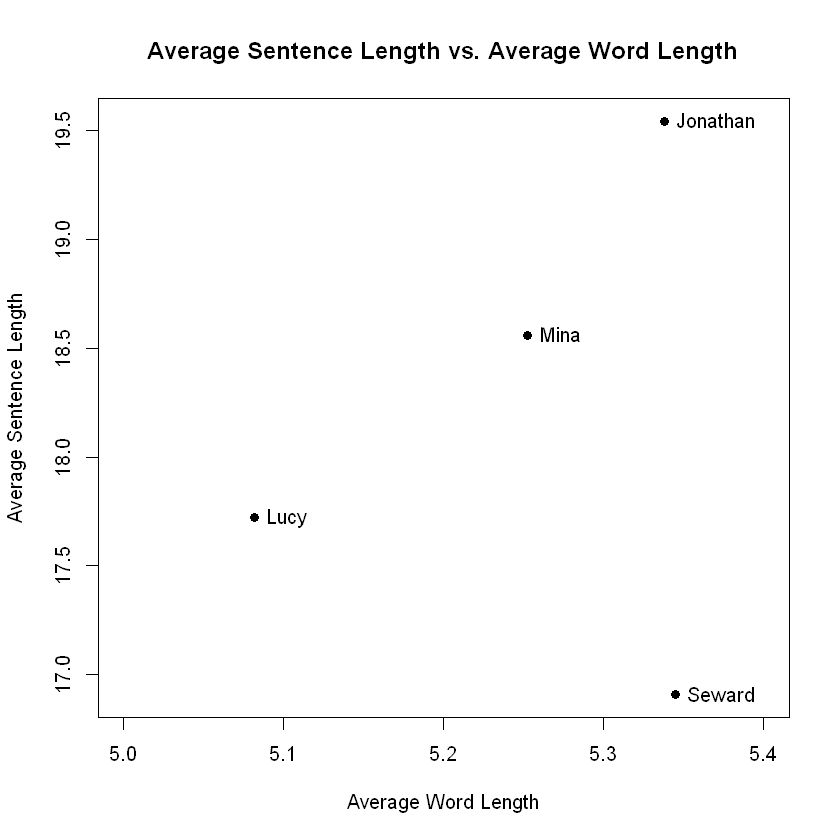

In [72]:
plot(as.vector(AWLTable), as.vector(WPSTable), pch = 19, main = "Average Sentence Length vs. Average Word Length",
     xlab = "Average Word Length", ylab = "Average Sentence Length", xlim = c(5, 5.4))
text(x=as.vector(AWLTable), y = as.vector(WPSTable), labels = c("Jonathan", "Lucy", "Seward", "Mina"), pos = 4)

Calculating the correlation, we can see that it is very low, indicative of Seward being the outlier

In [35]:
cor(as.vector(WPSTable), as.vector(AWLTable))

[1] 0.1839186

But if we remove Seward, we get a very high correlation between word length and sentence length. This may not be so useful just because of the relative limit of our data, but this idea can extend beyond just dracula

In [36]:
cor(as.vector(WPSTable)[-3], as.vector(AWLTable)[-3])

[1] 0.9723504

#### Graphing the Words Per Sentence

We can also visualize the words per sentence of each character and how they compare between authors. This gives us much more insight than just a raw average length.

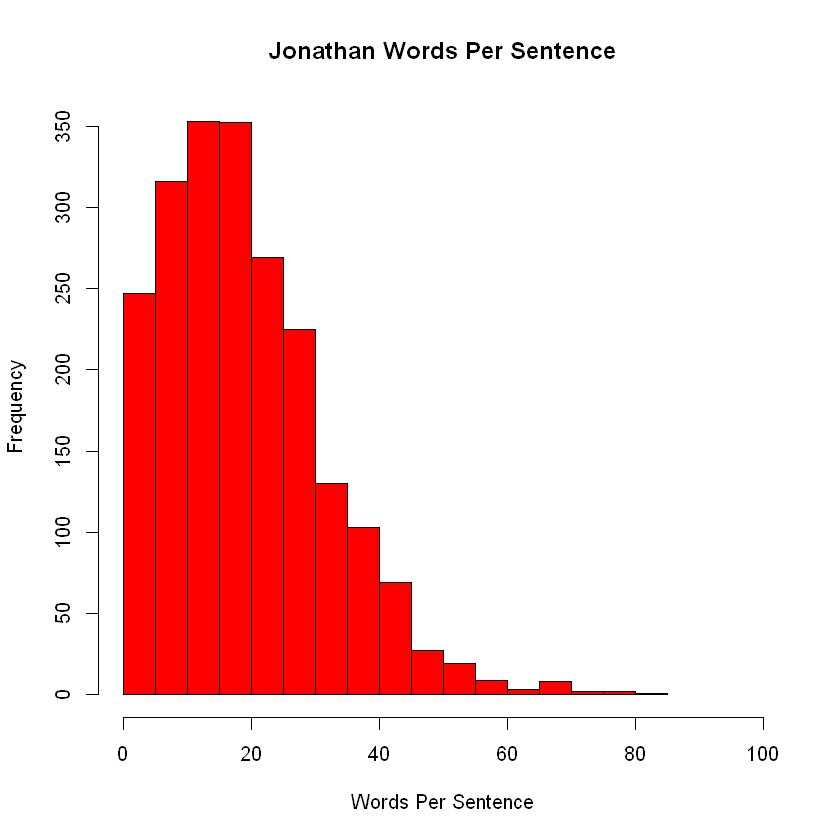

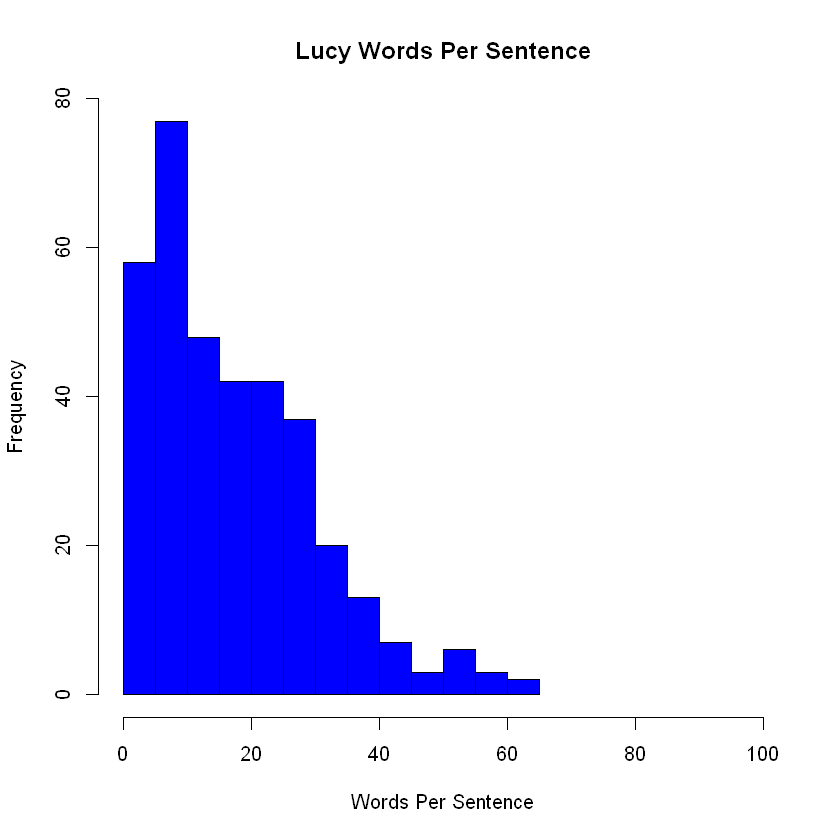

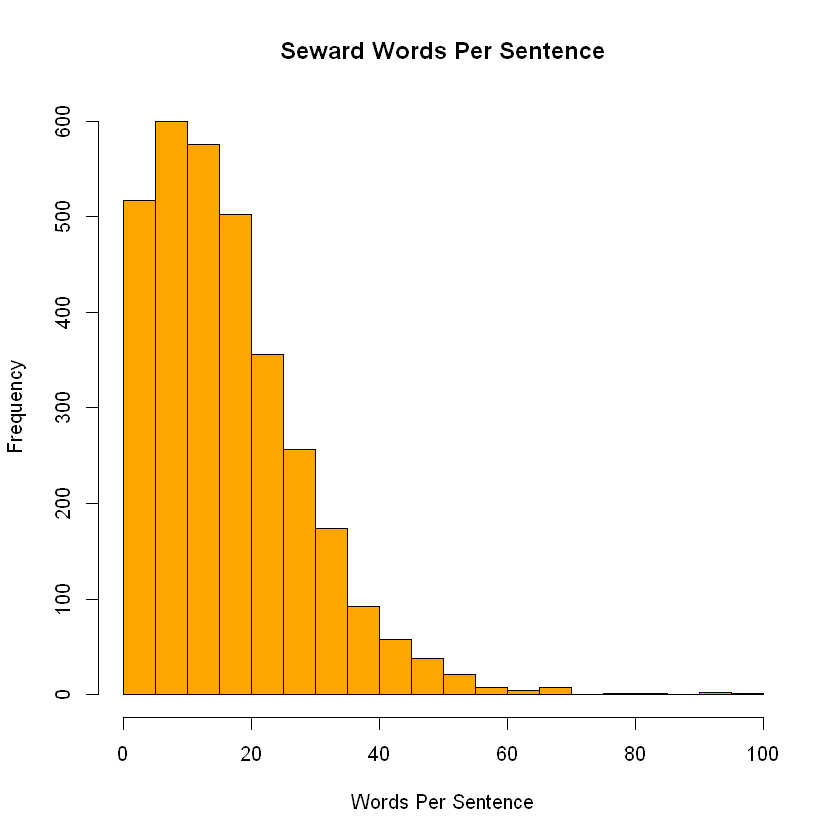

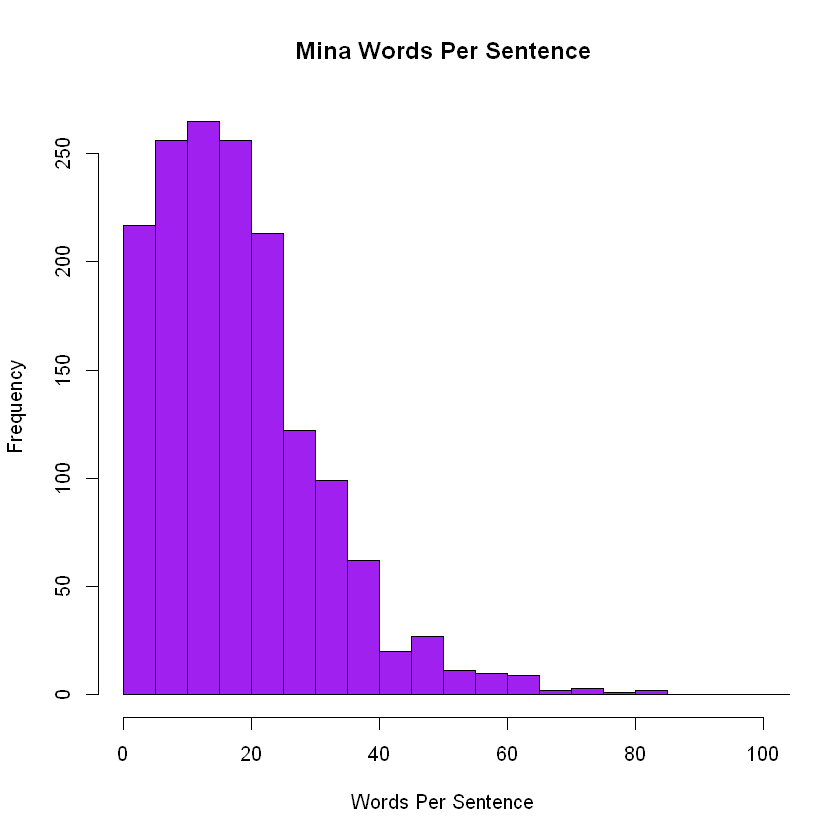

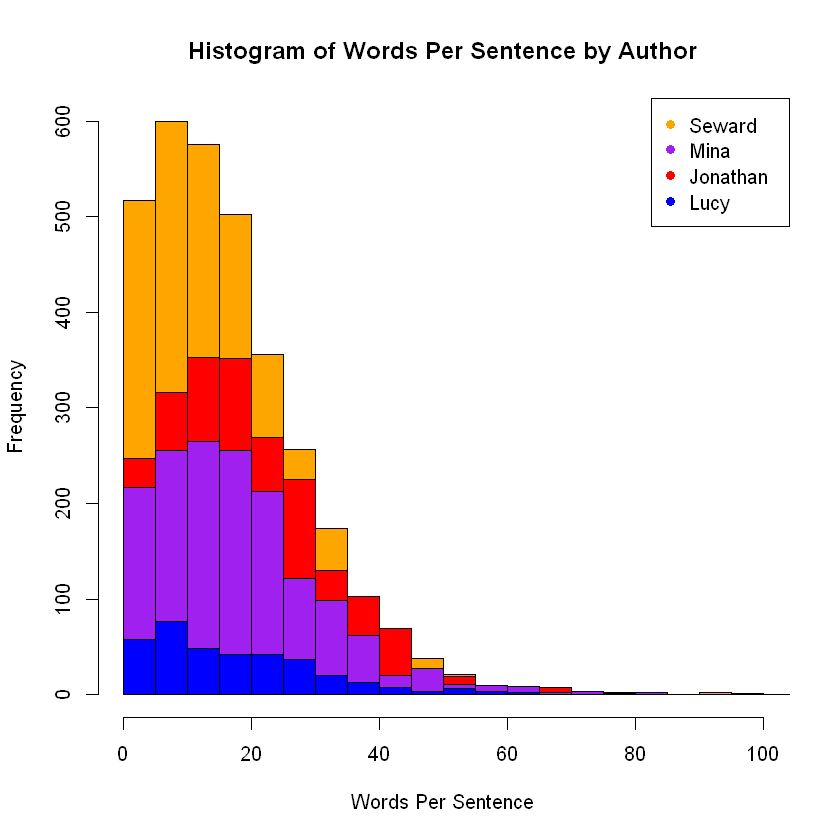

In [64]:
JH <- hist(JonathanWPS$n, col = "red", xlim = c(0,100), main = "Jonathan Words Per Sentence", xlab = "Words Per Sentence", breaks = 20)
LH <- hist(LucyWPS$n, col = "blue", xlim = c(0,100), main = "Lucy Words Per Sentence", xlab = "Words Per Sentence", breaks = 20)
SH <- hist(SewardWPS$n, col = "orange", xlim = c(0,100), main = "Seward Words Per Sentence", xlab = "Words Per Sentence", breaks = 20)
MH <- hist(MinaWPS$n, col = "purple", xlim = c(0,100), main = "Mina Words Per Sentence", xlab = "Words Per Sentence", breaks = 40)

plot(SH, col = "orange", main = "Histogram of Words Per Sentence by Author", xlab = "Words Per Sentence")
plot(JH, col = "red", add = T)
plot(MH, col = "purple", add = T)
plot(LH, col = "blue", add = T)
legend("topright", legend = c("Seward", "Mina", "Jonathan", "Lucy"), col = c("orange", "purple", "red", "blue"), pch = 19)

### Sentence Type

Another simple and easy way to get a lot of information about how different authors might be writing is by looking at the sentence type. An easy way to do this, albeit less accurate, is to just look at the ending punctuation marks for the sentences. To do this we can take our previous dataframe with all of the separate sentences, and then group them by author and find the number of declarative, interrogative, and exclamatory sentences by using endsWith. 

In [38]:
AuthorSentenceType <- DracSentences %>%
     group_by(Author) %>%
     summarise(Declarative = sum(endsWith(Sentence, ".")),
               Interrogative = sum(endsWith(Sentence, "?")),
               Exclamatory = sum(endsWith(Sentence, "!")))
AuthorSentenceType <- AuthorSentenceType[which(AuthorSentenceType$Author == "Jonathan" | 
                                               AuthorSentenceType$Author == "Lucy" |
                                               AuthorSentenceType$Author == "Seward" |
                                               AuthorSentenceType$Author == "Mina"),]
AuthorSentenceType

Author,Declarative,Interrogative,Exclamatory
Jonathan,1733,33,125
Lucy,294,14,21
Mina,1360,41,78
Seward,2399,120,179


These raw numbers don't tell us much though. We should instead convert them into percentages so we can really know what is going on.

In [39]:
sumrows <- rowSums(AuthorSentenceType[,-1])
AuthorSentenceType$Declarative <- AuthorSentenceType$Declarative / sumrows
AuthorSentenceType$Interrogative <- AuthorSentenceType$Interrogative / sumrows
AuthorSentenceType$Exclamatory <- AuthorSentenceType$Exclamatory / sumrows
AuthorSentenceType

Author,Declarative,Interrogative,Exclamatory
Jonathan,0.9164463,0.01745108,0.06610259
Lucy,0.8936170,0.04255319,0.06382979
Mina,0.9195402,0.02772143,0.05273834
Seward,0.8891772,0.04447739,0.06634544


#### Visualizing Sentence Type

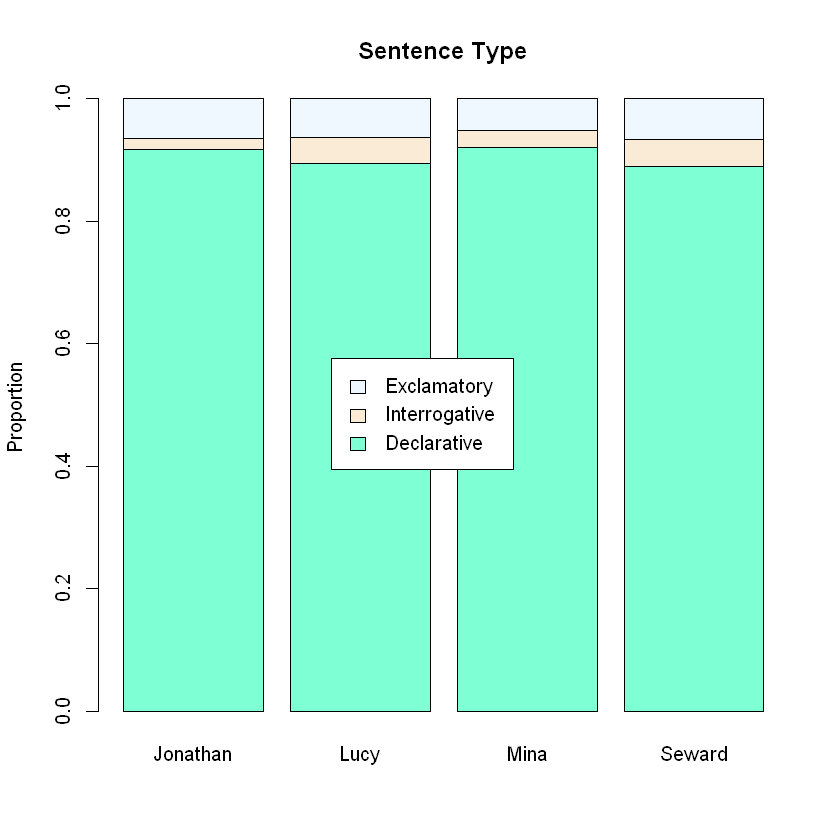

In [40]:
barplot(as.matrix(t(AuthorSentenceType[,-1])), main = "Sentence Type", col = c("aquamarine", "antiquewhite", "aliceblue" ),
names.arg = c("Jonathan", "Lucy", "Mina", "Seward"), ylab = "Proportion", 
legend.text = colnames(AuthorSentenceType[,-1]), args.legend = list(x = "bottomright", inset = c(.4, .4)))

### Visualizing with Wordclouds

Looking at what words are used frequently can give us some additional insight into what characters are writing about and how they are describing what's going on around them. Visualizing how these are different and similar across authors can give us understanding of what is going on in their head.

##### Full Text

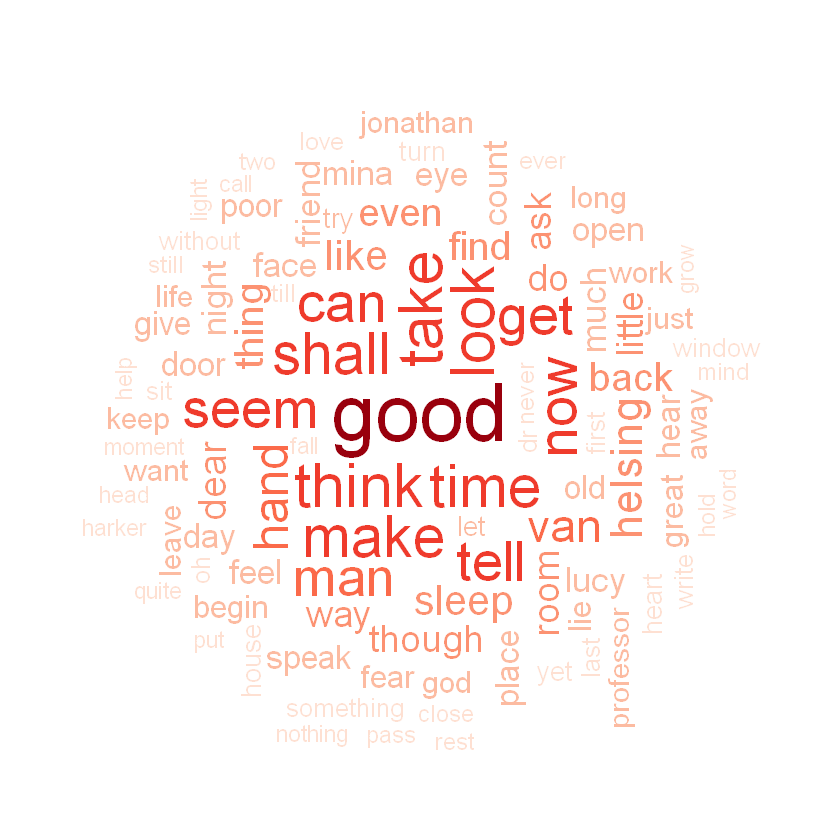

In [41]:
wordcloud(words = dracwords$word, freq = dracwords$n, random.order = F,
          rot.per = .35 , colors=brewer.pal(8, "Reds"), max.words = 100)

##### Jonathan

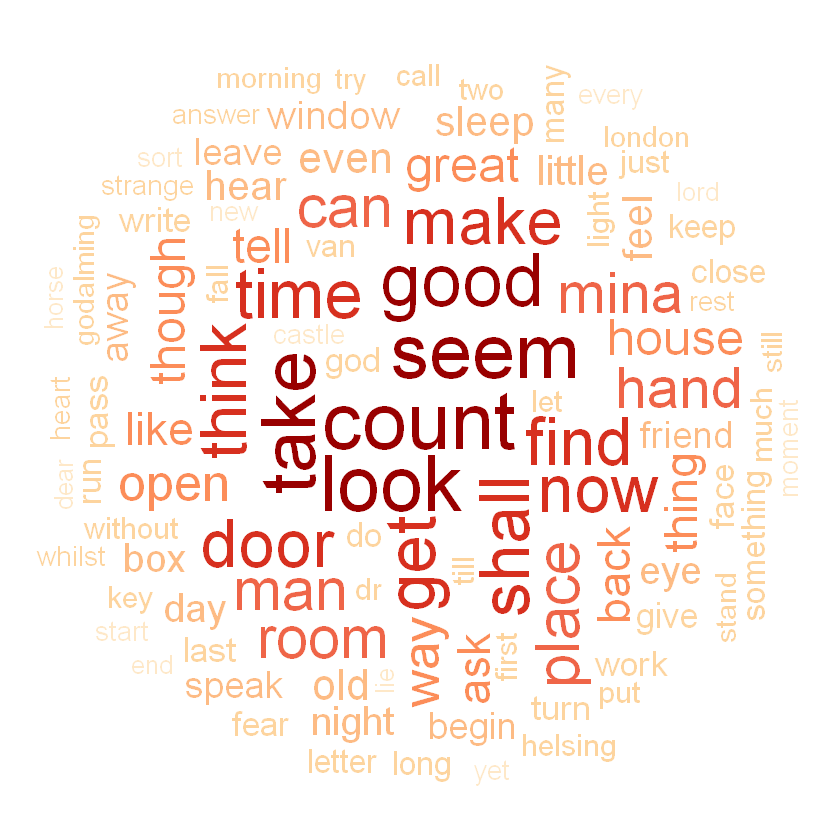

In [42]:
JonathanText <- DraculaEntries[which(DraculaEntries$Author == "Jonathan"),] %>% mutate(
  linenumber = row_number()) %>%
  ungroup() %>%
  unnest_tokens(word, Text)
JonathanWords <- JonathanText %>% count(word, sort=TRUE)
wordcloud(words = JonathanWords$word, freq = JonathanWords$n, random.order = F,
          rot.per = .35 , colors=brewer.pal(8, "OrRd"), max.words = 100)

#### Most Used Words For Jonathan


In [43]:
head(JonathanWords, 10)

word,n
count,124
look,121
seem,119
take,115
good,112
shall,105
get,104
time,104
door,99
find,99


##### Lucy

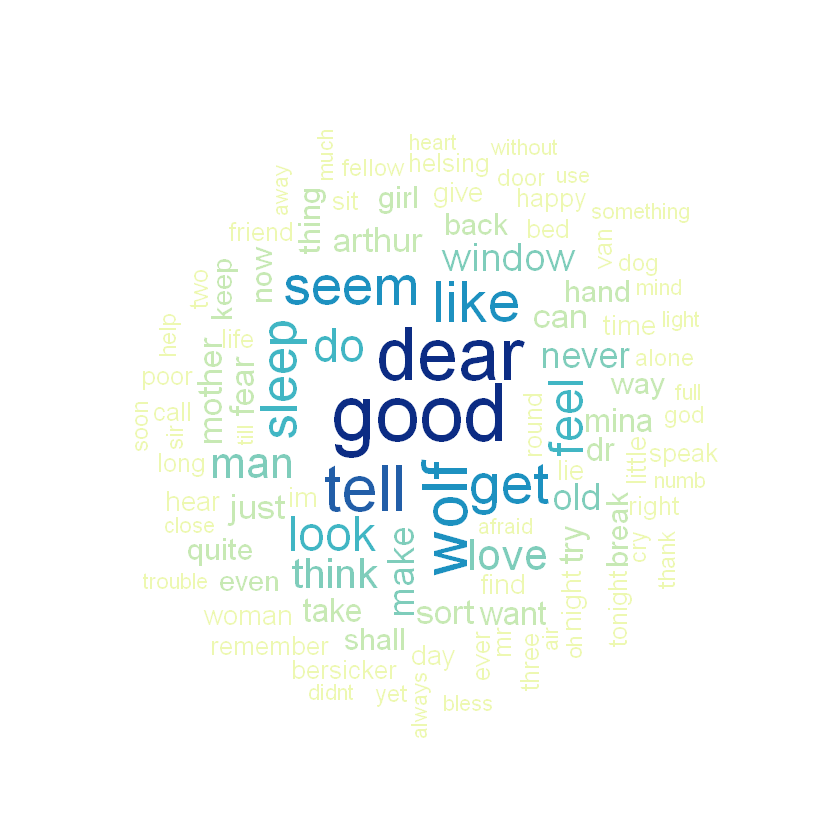

In [44]:
LucyText <- DraculaEntries[which(DraculaEntries$Author == "Lucy"),] %>% mutate(
  linenumber = row_number()) %>%
  ungroup() %>%
  unnest_tokens(word, Text)
LucyWords <- LucyText %>% count(word, sort=TRUE)
wordcloud(words = LucyWords$word, freq = LucyWords$n, random.order = F,
          rot.per = .35 , colors=brewer.pal(8, "YlGnBu"), max.words = 100)

#### Most Used Words For Lucy

In [45]:
head(LucyWords, 10)

word,n
good,36
dear,33
tell,28
wolf,27
get,24
like,24
seem,23
sleep,21
feel,20
look,20


##### Seward

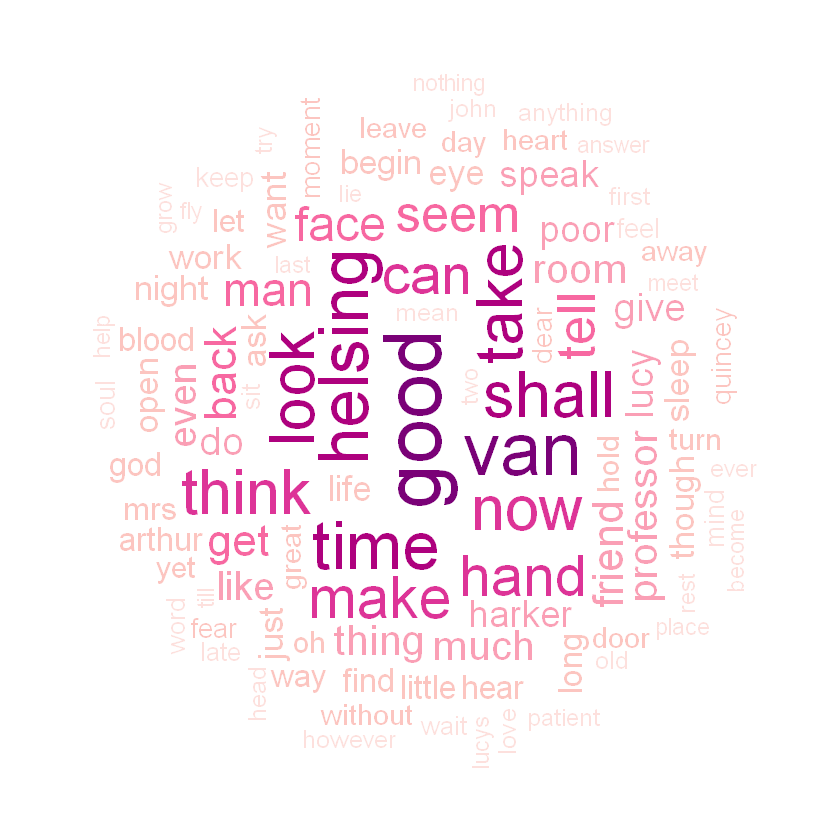

In [46]:
SewardText <- DraculaEntries[which(DraculaEntries$Author == "Seward"),] %>% mutate(
  linenumber = row_number()) %>%
  ungroup() %>%
  unnest_tokens(word, Text)
SewardWords <- SewardText %>% count(word, sort=TRUE)
wordcloud(words = SewardWords$word, freq = SewardWords$n, random.order = F,
          rot.per = .35 , colors=brewer.pal(8, "RdPu"), max.words = 100)

#### Most Used Words For Seward

In [47]:
head(SewardWords, 10)

word,n
good,211
van,191
helsing,178
time,171
shall,162
take,162
look,159
now,157
think,157
make,146


##### Mina

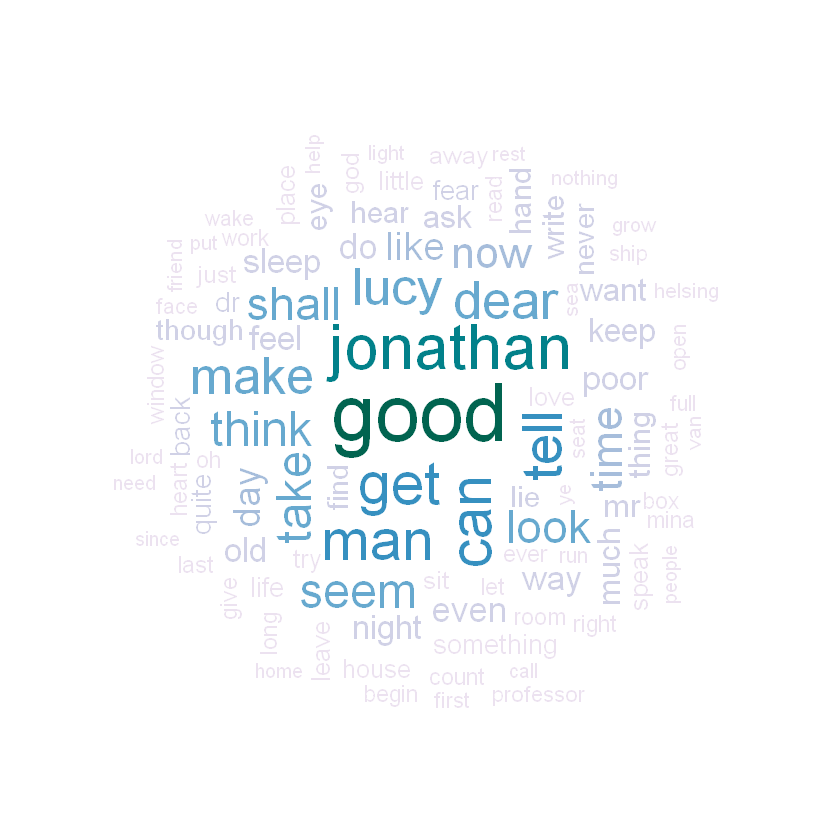

In [48]:
MinaText <- DraculaEntries[which(DraculaEntries$Author == "Mina"),] %>% mutate(
  linenumber = row_number()) %>%
  ungroup() %>%
  unnest_tokens(word, Text)
MinaWords <- MinaText %>% count(word, sort=TRUE)
wordcloud(words = MinaWords$word, freq = MinaWords$n, random.order = F,
          rot.per = .35 , colors=brewer.pal(8, "PuBuGn"), max.words = 100)

#### Most Used Words For Mina

In [49]:
head(MinaWords, 10)

word,n
good,137
jonathan,103
get,97
can,93
man,92
tell,90
dear,84
lucy,80
make,80
think,77


### Sentiment Analysis

For the different authors, as well as the full text, we can look at the overall sentiment that they have towards the events that are transpiring in the novel. Sentiment Analysis relies on taking lexicons with words delineated as positive, negative, or neutral and leveraging that into an overall score for positivity and negativity of a piece of text. For our purposes, we want to look at each dated entry and whether it is positive or negative. While there is not have a gothic lexicon available, we can still use modern ones to gain some understanding. This analysis can be a good starting point to see how feelings evolve and change over time.

#### Full Text

Joining, by = "word"



[1] 34

[1] -134

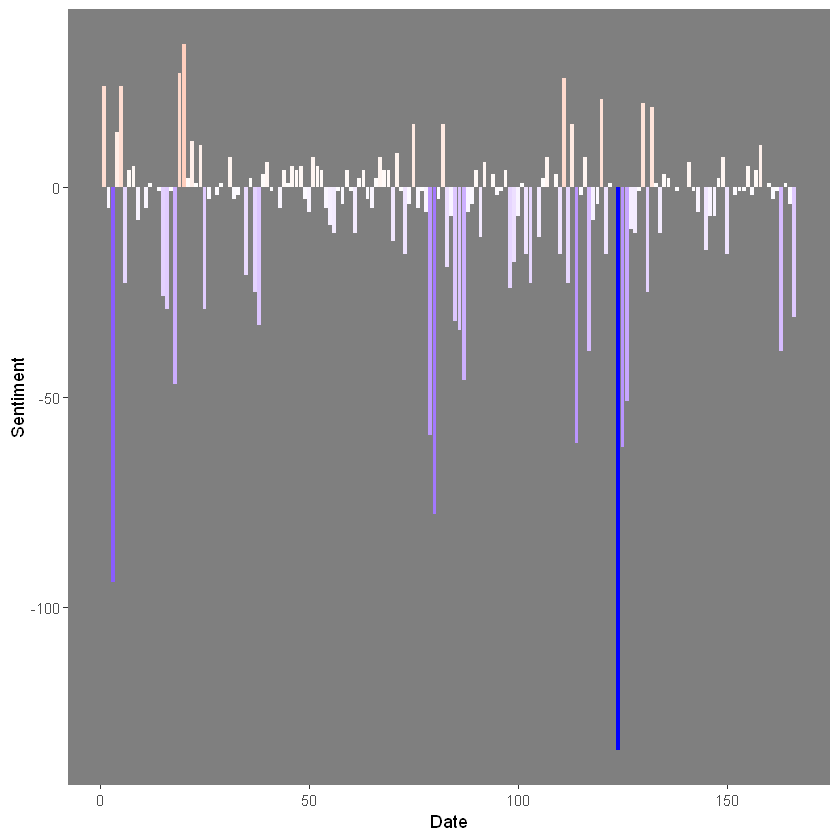

In [50]:
Drac_sentiment <- DracAuthWords %>%
  inner_join(get_sentiments("bing")) %>%
  count(linenumber, sentiment) %>%
  spread(sentiment, n, fill = 0) %>% 
  mutate(sentiment = positive - negative)
Drac_sentiment$date <- DraculaEntries$date[Drac_sentiment$linenumber]
Drac_sentiment$date <- as.Date(Drac_sentiment$date, format = "%b-%d")
Drac_sentiment <- Drac_sentiment[order(Drac_sentiment$date),]


max(Drac_sentiment$sentiment)
min(Drac_sentiment$sentiment)
ggplot(Drac_sentiment, aes(x = linenumber, y = sentiment, fill = sentiment)) + geom_col(show.legend = FALSE) + 
  scale_fill_gradient2(low = "blue", mid = "white" , high = "red", limit = c(-134,34)) + theme_dark() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  xlab("Date") + ylab("Sentiment")

#### Jonathan

Joining, by = "word"



[1] 24

[1] -94

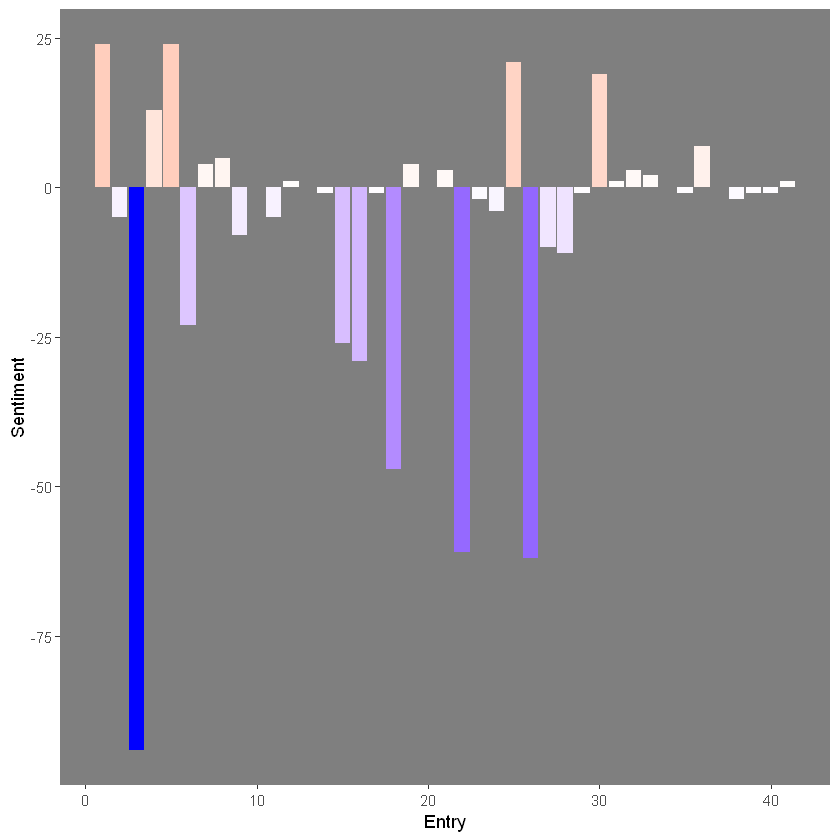

In [51]:
Jonathan_sentiment <- DracAuthWords[which(DracAuthWords$Author == "Jonathan"),] %>%
  inner_join(get_sentiments("bing")) %>%
  count(linenumber, sentiment) %>%
  spread(sentiment, n, fill = 0) %>% 
  mutate(sentiment = positive - negative)
Jonathan_sentiment$row <- 1:nrow(Jonathan_sentiment)

max(Jonathan_sentiment$sentiment)
min(Jonathan_sentiment$sentiment)
ggplot(Jonathan_sentiment, aes(row, sentiment, fill = sentiment)) + geom_col(show.legend = FALSE) + 
  scale_fill_gradient2(low = "blue", mid = "white" , high = "red", limit = c(-94,24)) + theme_dark() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  xlab("Entry") + ylab("Sentiment")

#### Lucy

Joining, by = "word"



[1] 34

[1] -59

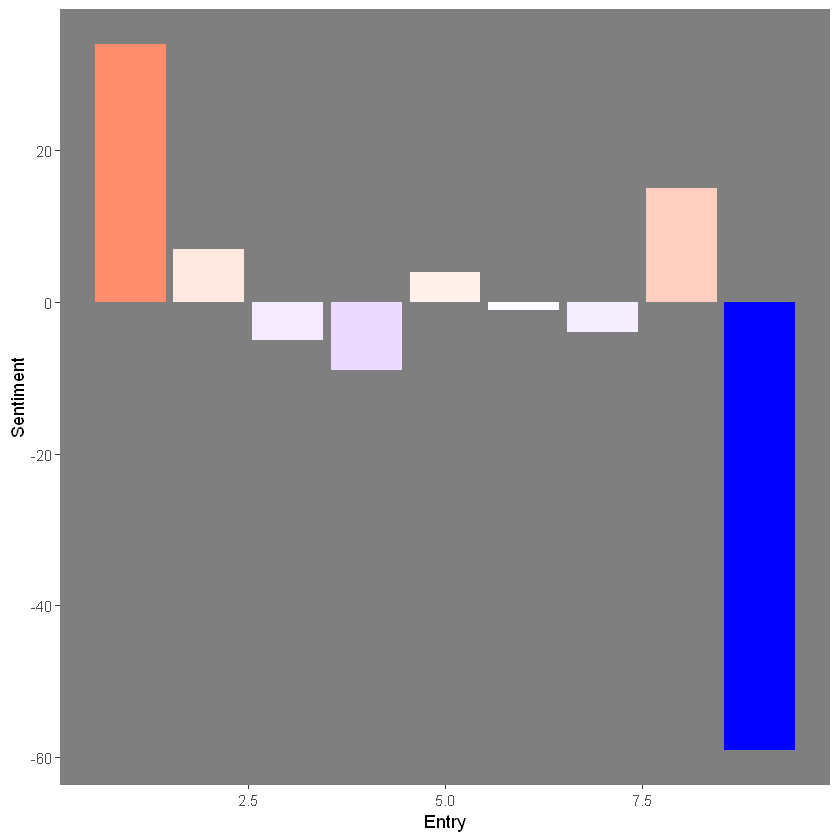

In [52]:
Lucy_sentiment <- DracAuthWords[which(DracAuthWords$Author == "Lucy"),] %>%
  inner_join(get_sentiments("bing")) %>%
  count(linenumber, sentiment) %>%
  spread(sentiment, n, fill = 0) %>% 
  mutate(sentiment = positive - negative)
Lucy_sentiment$row <- 1:nrow(Lucy_sentiment)

max(Lucy_sentiment$sentiment)
min(Lucy_sentiment$sentiment)
ggplot(Lucy_sentiment, aes(row, sentiment, fill = sentiment)) + geom_col(show.legend = FALSE) + 
  scale_fill_gradient2(low = "blue", mid = "white" , high = "red", limit = c(-59,34)) + theme_dark() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  xlab("Entry") + ylab("Sentiment")

#### Seward

Joining, by = "word"



[1] 26

[1] -134

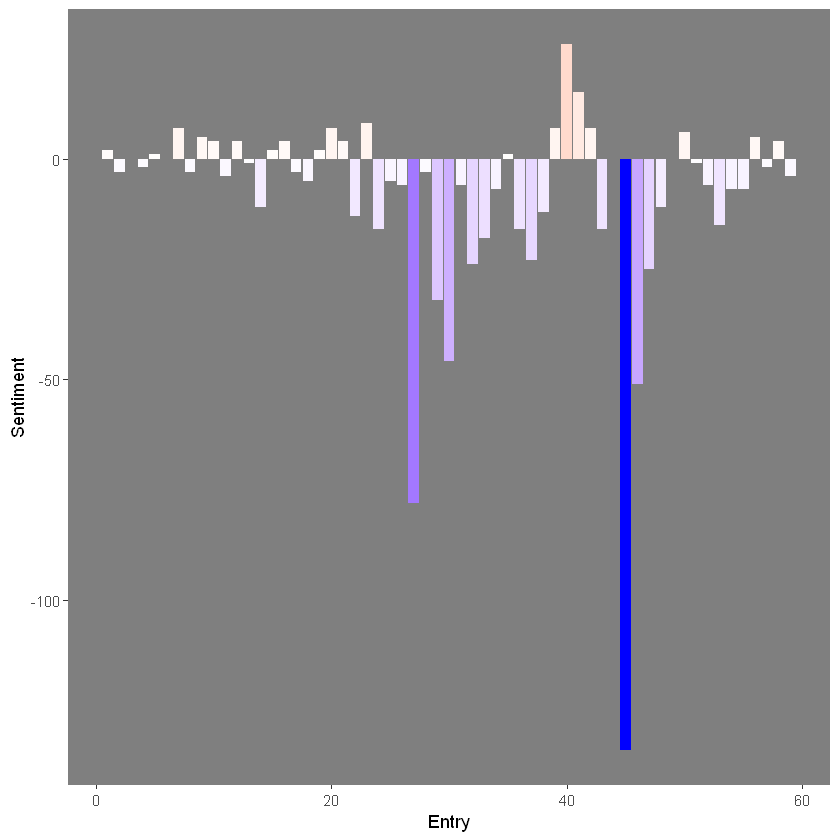

In [53]:
Seward_sentiment <- DracAuthWords[which(DracAuthWords$Author == "Seward"),] %>%
  inner_join(get_sentiments("bing")) %>%
  count(linenumber, sentiment) %>%
  spread(sentiment, n, fill = 0) %>% 
  mutate(sentiment = positive - negative)
Seward_sentiment$row <- 1:nrow(Seward_sentiment)

max(Seward_sentiment$sentiment)
min(Seward_sentiment$sentiment)
ggplot(Seward_sentiment, aes(row, sentiment, fill = sentiment)) + geom_col(show.legend = FALSE) + 
  scale_fill_gradient2(low = "blue", mid = "white" , high = "red", limit = c(-134,26)) + theme_dark() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  xlab("Entry") + ylab("Sentiment")

#### Mina

Joining, by = "word"



[1] 27

[1] -39

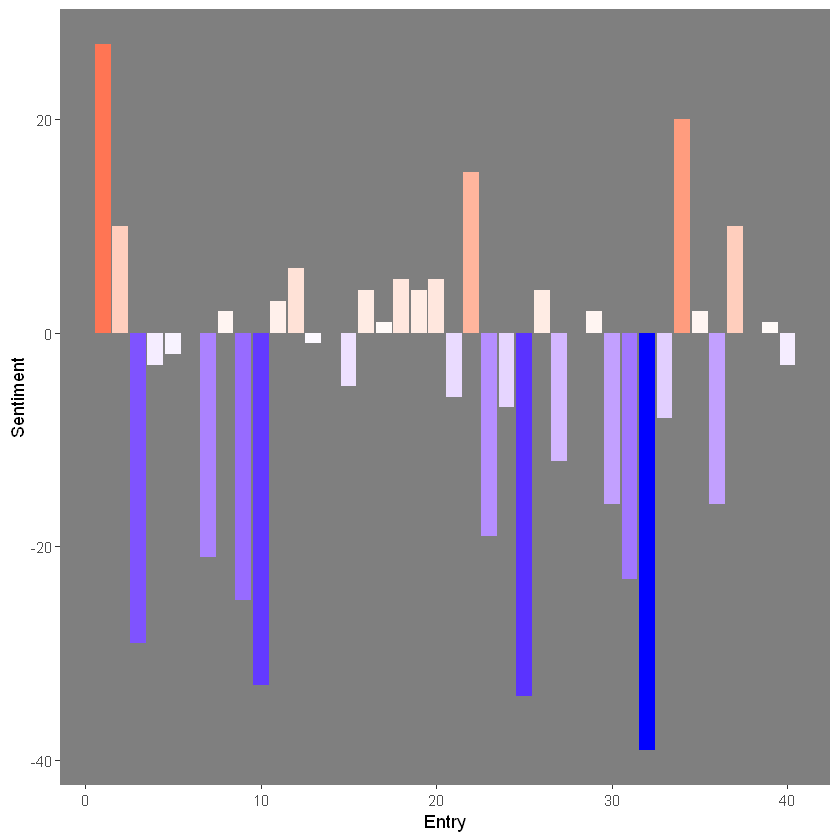

In [54]:
Mina_sentiment <- DracAuthWords[which(DracAuthWords$Author == "Mina"),] %>%
  inner_join(get_sentiments("bing")) %>%
  count(linenumber, sentiment) %>%
  spread(sentiment, n, fill = 0) %>% 
  mutate(sentiment = positive - negative)
Mina_sentiment$row <- 1:nrow(Mina_sentiment)

max(Mina_sentiment$sentiment)
min(Mina_sentiment$sentiment)
ggplot(Mina_sentiment, aes(row, sentiment, fill = sentiment)) + geom_col(show.legend = FALSE) + 
  scale_fill_gradient2(low = "blue", mid = "white" , high = "red", limit = c(-39,27)) + theme_dark() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  xlab("Entry") + ylab("Sentiment")

### Sentiment Towards Dracula

The analysis on the sentiment towards a character is far less accurate than towards the whole text, but it stil might be interesting to look at. In this case, we are going to look at how each of the authors feel about Dracula as the novel progresses by looking at the sentiment of the sentences that he is mentioned in. It should be noted that this may not be super accurate, but interesting to look at nonetheless.

Joining, by = "word"



[1] 3

[1] -5

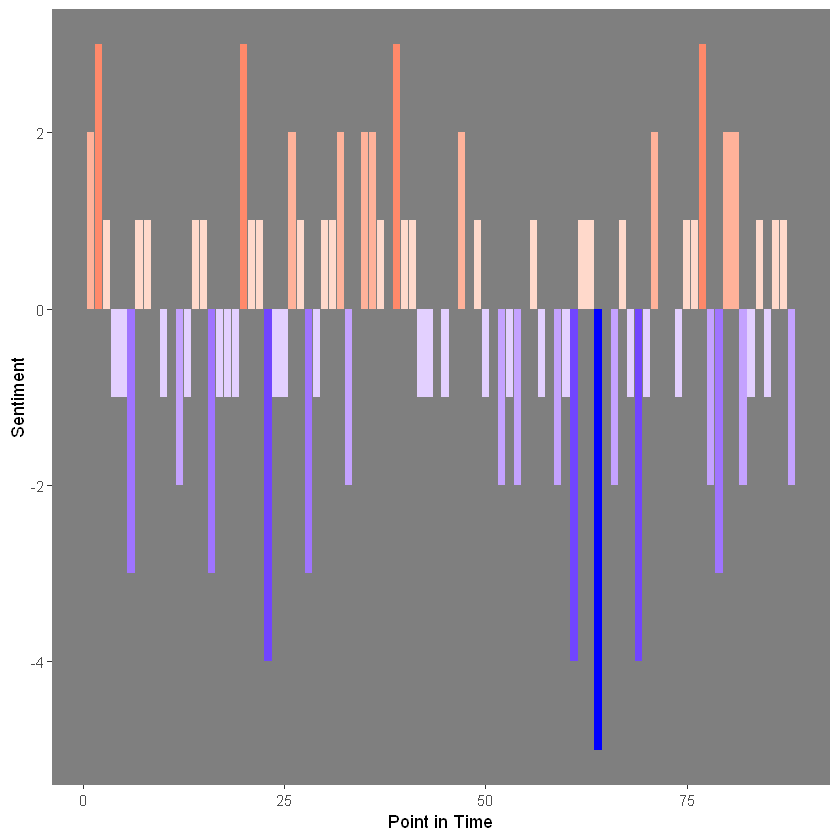

In [55]:
dracplace <- vector()
for(val in 1:nrow(DracSentences))
{
  if(str_detect(DracSentences$Sentence[val], " count |\\count | dracula |\\dracula ")
     | str_detect(DracSentences$Sentence[val], fixed("count.")) 
     | str_detect(DracSentences$Sentence[val], fixed("dracula.")))
  {
    dracplace <- append(dracplace, val)
  }
}

DracAppears <- DracSentences[dracplace,]
DracAppears <- DracAppears %>% mutate(
  sentencenumber = dracplace) %>%
  ungroup() %>%
  unnest_tokens(word, Sentence)
DracAppears_sentiment <- DracAppears %>%
  inner_join(get_sentiments("bing")) %>%
  count(sentencenumber, sentiment) %>%
  spread(sentiment, n, fill = 0) %>% 
  mutate(sentiment = positive - negative)
DracAppears_sentiment$n <- 1:nrow(DracAppears_sentiment)

max(DracAppears_sentiment$sentiment)
min(DracAppears_sentiment$sentiment)
ggplot(DracAppears_sentiment, aes(n, sentiment, fill = sentiment)) + geom_col(show.legend = FALSE) + 
  scale_fill_gradient2(low = "blue", mid = "white" , high = "red", limit = c(-5,3)) + theme_dark() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  xlab("Point in Time") + ylab("Sentiment")

In [56]:
DracAppears_sentiment[which.min(DracAppears_sentiment$sentiment),]
DracSentences$Sentence[5923]

sentencenumber,negative,positive,sentiment,n
5923,5,0,-5,64


[1] "i did not mention this last lest it should give her needless pain; but it made my blood run cold in my veins to think of what had occurred with poor lucy when the count had sucked her blood."

#### Jonathan

Joining, by = "word"



[1] 3

[1] -5

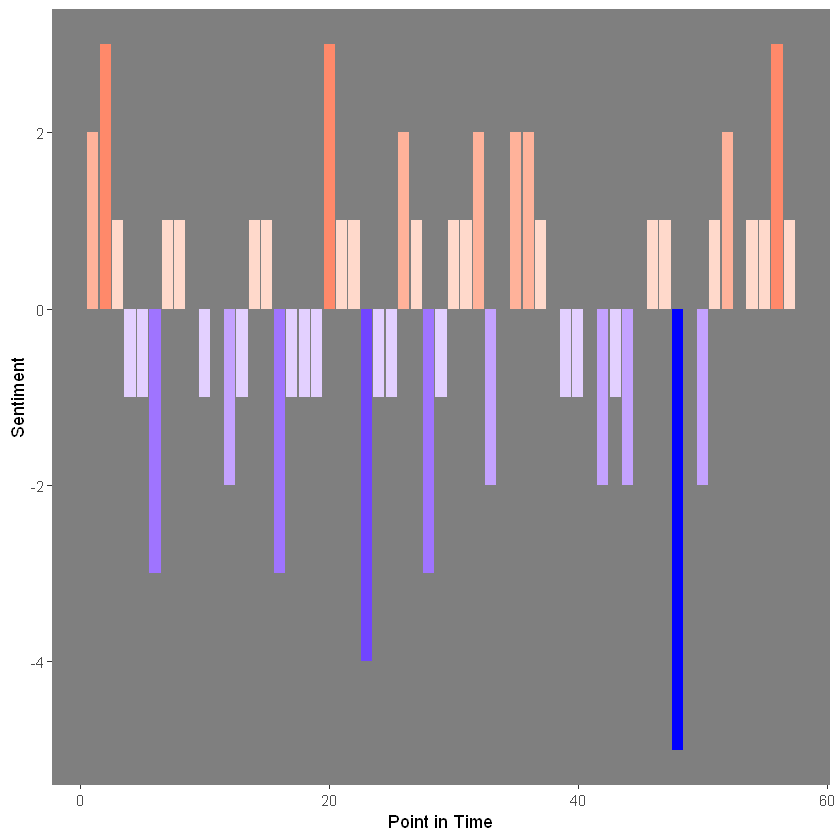

In [57]:
JonathanToDrac <- DracAppears[which(DracAppears$Author == "Jonathan"),]
JonathanToDracSent <- JonathanToDrac %>%
  inner_join(get_sentiments("bing")) %>%
  count(sentencenumber, sentiment) %>%
  spread(sentiment, n, fill = 0) %>% 
  mutate(sentiment = positive - negative)
JonathanToDracSent$n <- 1:nrow(JonathanToDracSent)

max(JonathanToDracSent$sentiment)
min(JonathanToDracSent$sentiment)
ggplot(JonathanToDracSent, aes(n, sentiment, fill = sentiment)) + geom_col(show.legend = FALSE) + 
  scale_fill_gradient2(low = "blue", mid = "white" , high = "red", limit = c(-5,3)) + theme_dark() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  xlab("Point in Time") + ylab("Sentiment")

In [58]:
DracSentences$Sentence[6876]

[1] "everything is pretty well fixed now i think to welcome the count on his return from his tour."

#### Seward

Joining, by = "word"



[1] 2

[1] -4

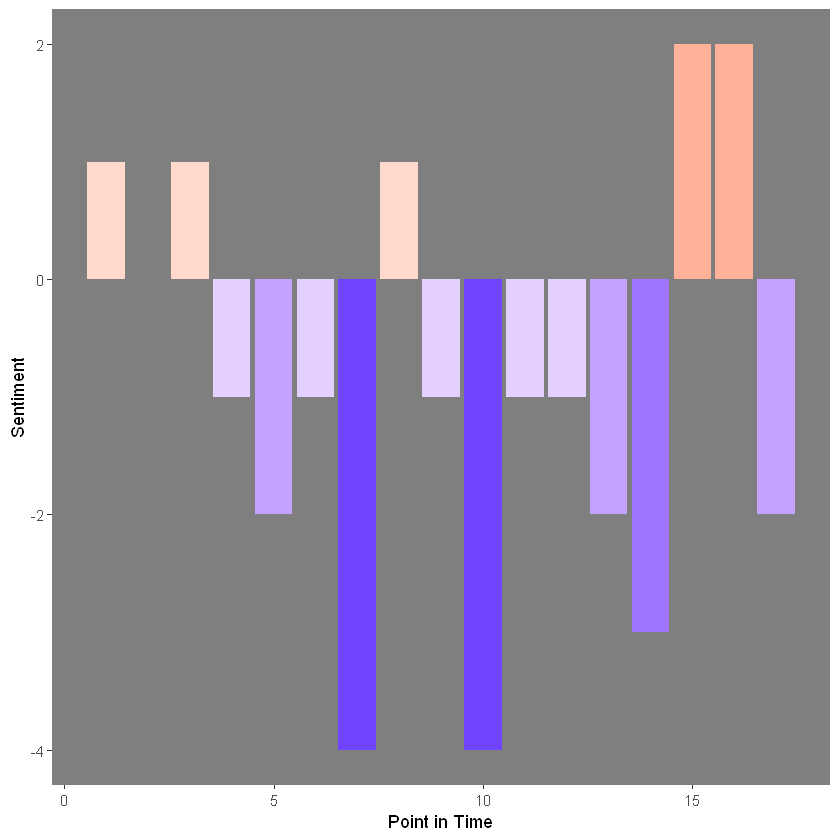

In [59]:
SewardToDrac <- DracAppears[which(DracAppears$Author == "Seward"),]
SewardToDracSent <- SewardToDrac %>%
  inner_join(get_sentiments("bing")) %>%
  count(sentencenumber, sentiment) %>%
  spread(sentiment, n, fill = 0) %>% 
  mutate(sentiment = positive - negative)
SewardToDracSent$n <- 1:nrow(SewardToDracSent)

max(SewardToDracSent$sentiment)
min(SewardToDracSent$sentiment)
ggplot(SewardToDracSent, aes(n, sentiment, fill = sentiment)) + geom_col(show.legend = FALSE) + 
  scale_fill_gradient2(low = "blue", mid = "white" , high = "red", limit = c(-5,3)) + theme_dark() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  xlab("Point in Time") + ylab("Sentiment")

#### Mina

Joining, by = "word"



[1] 2

[1] -1

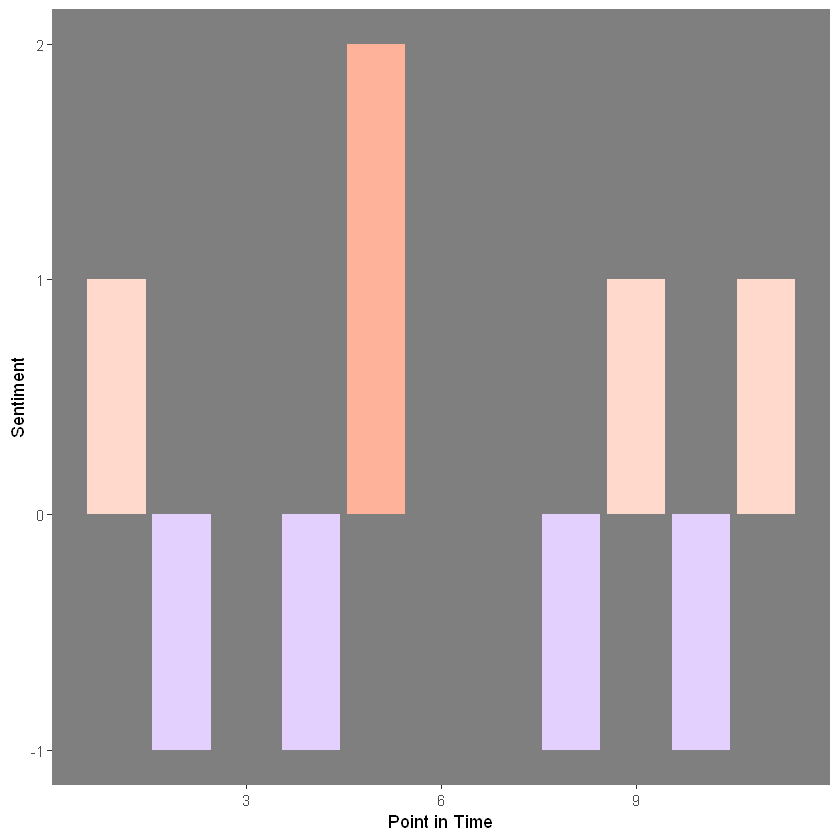

In [60]:
MinaToDrac <- DracAppears[which(DracAppears$Author == "Mina"),]
MinaToDracSent <- MinaToDrac %>%
  inner_join(get_sentiments("bing")) %>%
  count(sentencenumber, sentiment) %>%
  spread(sentiment, n, fill = 0) %>% 
  mutate(sentiment = positive - negative)
MinaToDracSent$n <- 1:nrow(MinaToDracSent)

max(MinaToDracSent$sentiment)
min(MinaToDracSent$sentiment)
ggplot(MinaToDracSent, aes(n, sentiment, fill = sentiment)) + geom_col(show.legend = FALSE) + 
  scale_fill_gradient2(low = "blue", mid = "white" , high = "red", limit = c(-5,3)) + theme_dark() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  xlab("Point in Time") + ylab("Sentiment")